# Housekeeping

In [3]:
options(repr.plot.width=14,repr.plot.antialias='subpixel',repr.plot.res=218)
sessionInfo()
update.packages()

R version 4.0.3 Patched (2020-10-12 r79333)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.3  ellipsis_0.3.1  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_4.0.3     htmltools_0.5.0 pillar_1.4.6    base64enc_0.1-3
 [9] crayon_1.3.4    uuid_0.1-4      IRkernel_1.1.1  jsonlite_1.7.1 
[13] digest_0.6.25   lifecycle_0.2.0 repr_1.1.0      rlang_0.4.8    
[17] evaluate_0.14  

#  Browser spending analysis 

Load the data first.

In [4]:
browser = read.csv("web-browsers.csv")

Let's try a histogram

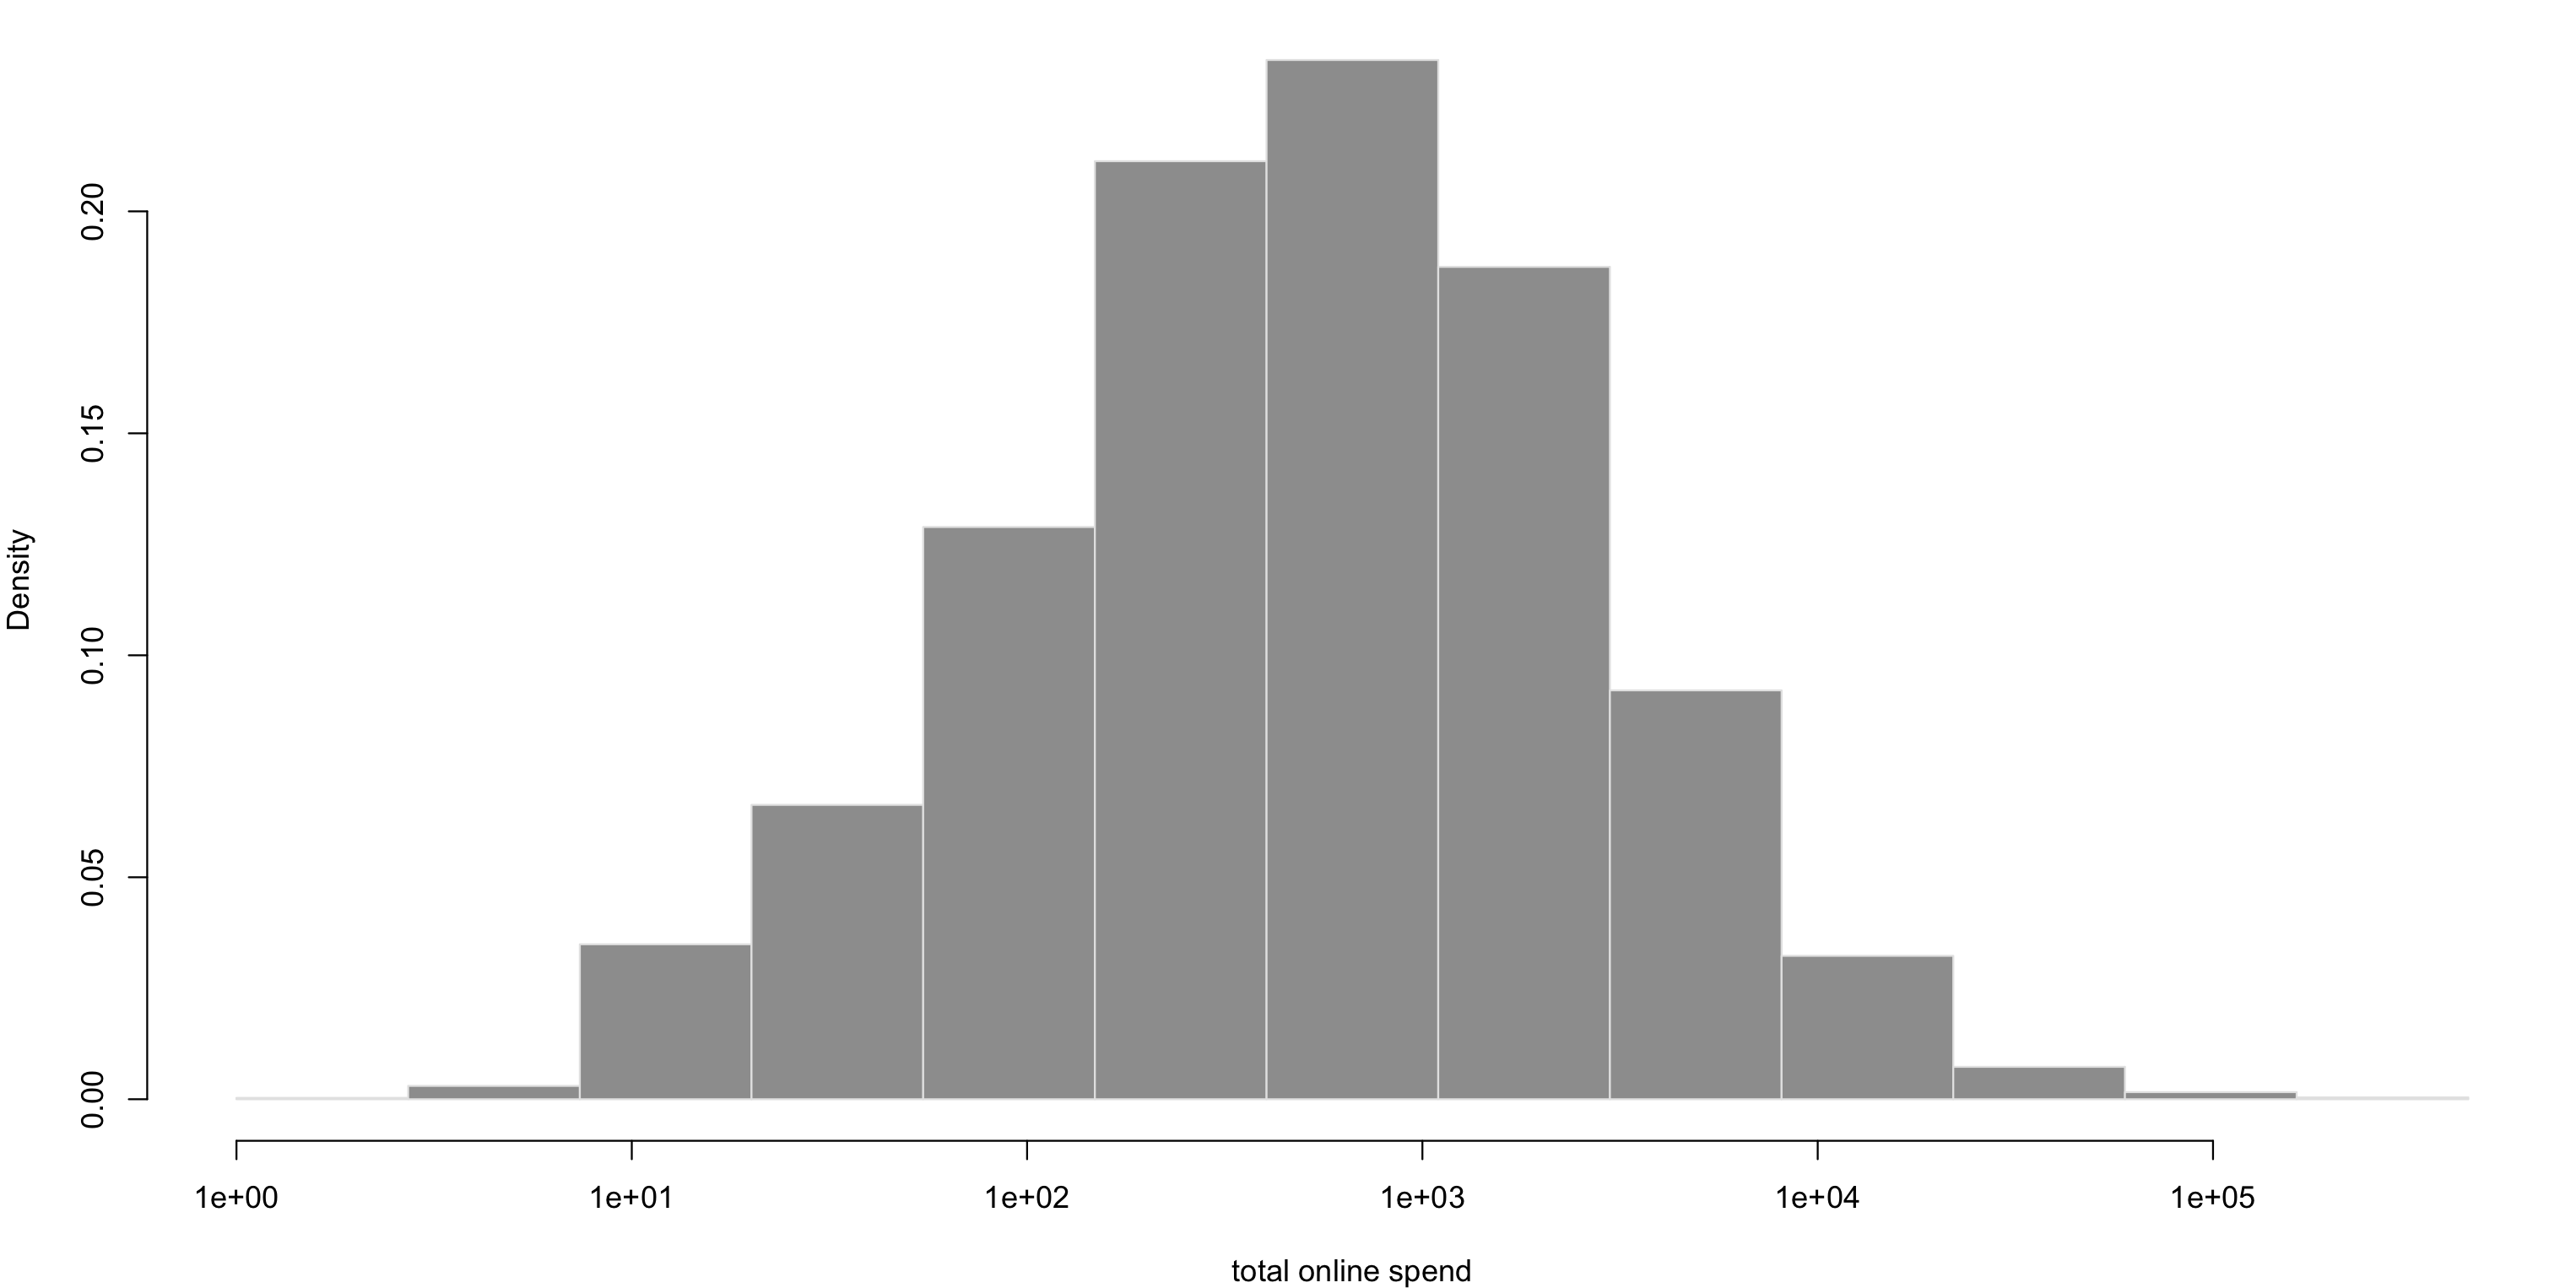

In [5]:
par(mai=c(.8,.8,.1,.1))
hist(log(browser$spend), freq=FALSE,
	xaxt="n", main="", xlab="total online spend", col=8, border="grey90")
lgrid = c(1,10,100,1000,10000,100000)
axis(1, at=log(lgrid), labels=sprintf("%.0e",lgrid))

Now we can look at some basic statistics: number of observations, mean and its variance:

In [6]:
nrow(browser)
mean(browser$spend)
var(browser$spend)/nrow(browser)

[1] 10000

[1] 1946.439

[1] 6461.925

Let's store some values that let's us specify which normal distribution the mean of a random sample should come from. Then plot it.

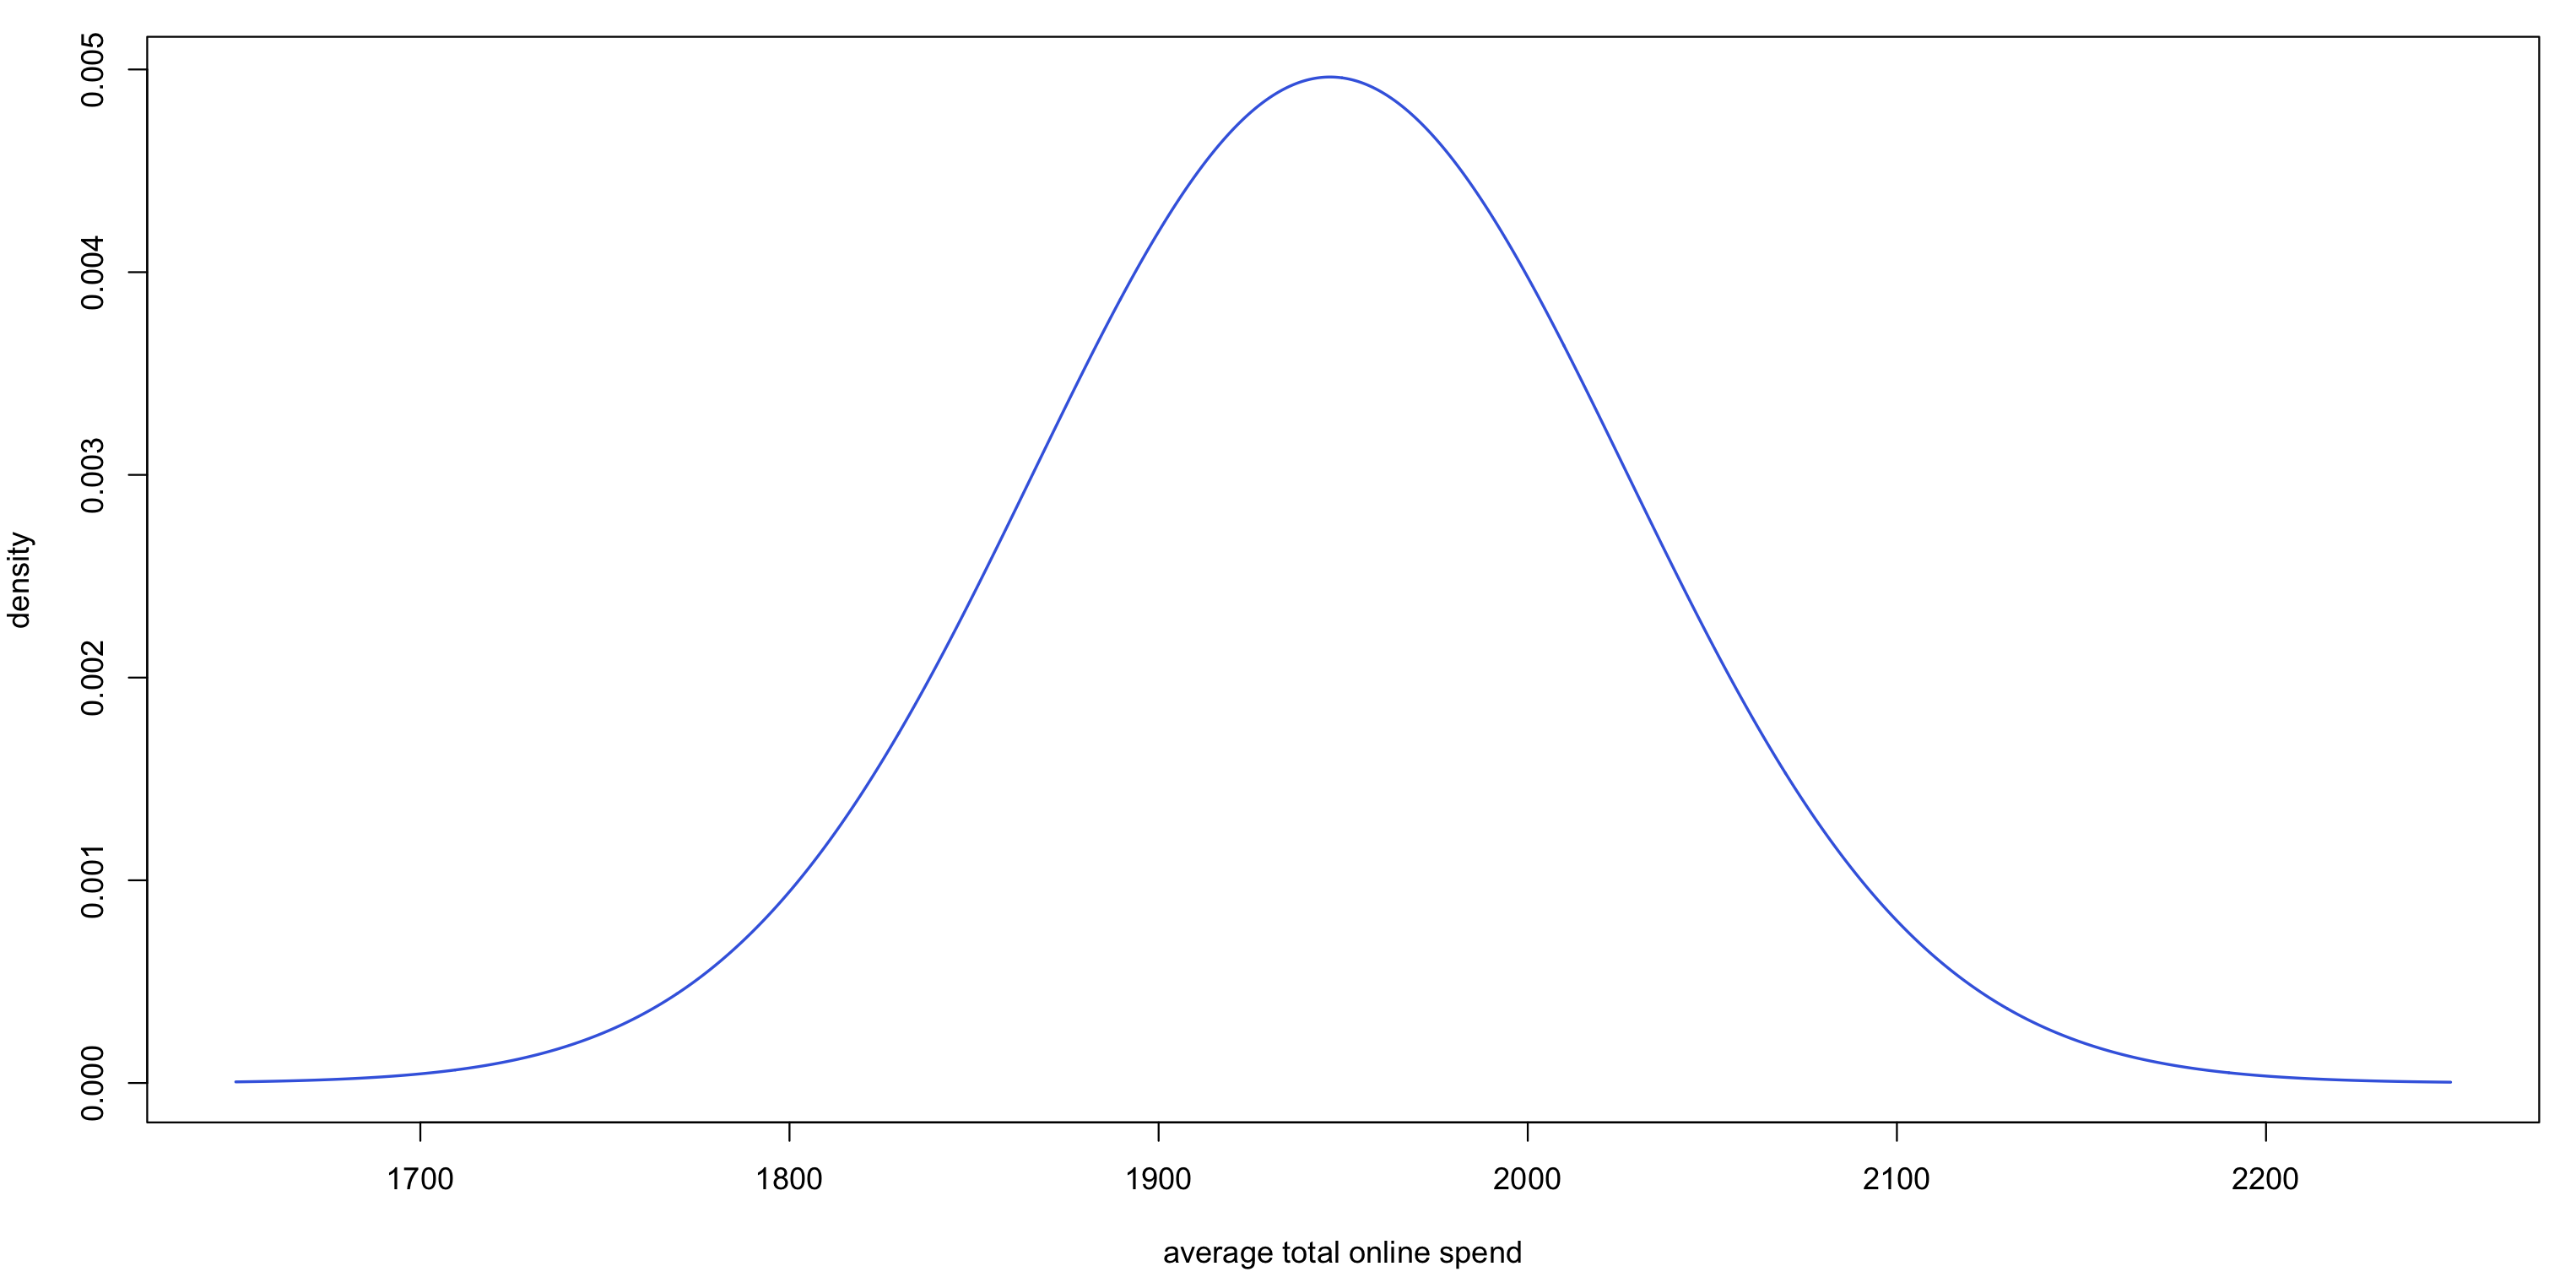

In [7]:
xbar <- mean(browser$spend)
xbse <-  sd(browser$spend)/sqrt(nrow(browser))

xx <- seq(1650,2250,length=1000)

par(mai=c(.9,.8,.2,.2))
plot(xx, dnorm(xx, xbar, xbse), type="l", col="royalblue", lwd=1.5,
	xlab="average total online spend", ylab="density")

Let's simulate what having 10000 such samples would do for us. This is the nonparametric bootstrap, where we just keep resampling from our actual data.

After storing some parameter and initializing an empty vector that should grow with every iteration, we need a simple for loop.

In [8]:
B <- 10000
mub <- c()
for (b in 1:B){
	samp_b = sample.int(nrow(browser), replace=TRUE)
	mub <- c(mub, mean(browser$spend[samp_b]))
}

Let's check the sampling error (standard deviation) of these means of all the bootstrap samples.

In [9]:
sd(mub)

[1] 80.13013

We can overlay the histogram of these means to the normal distribution we were promised.

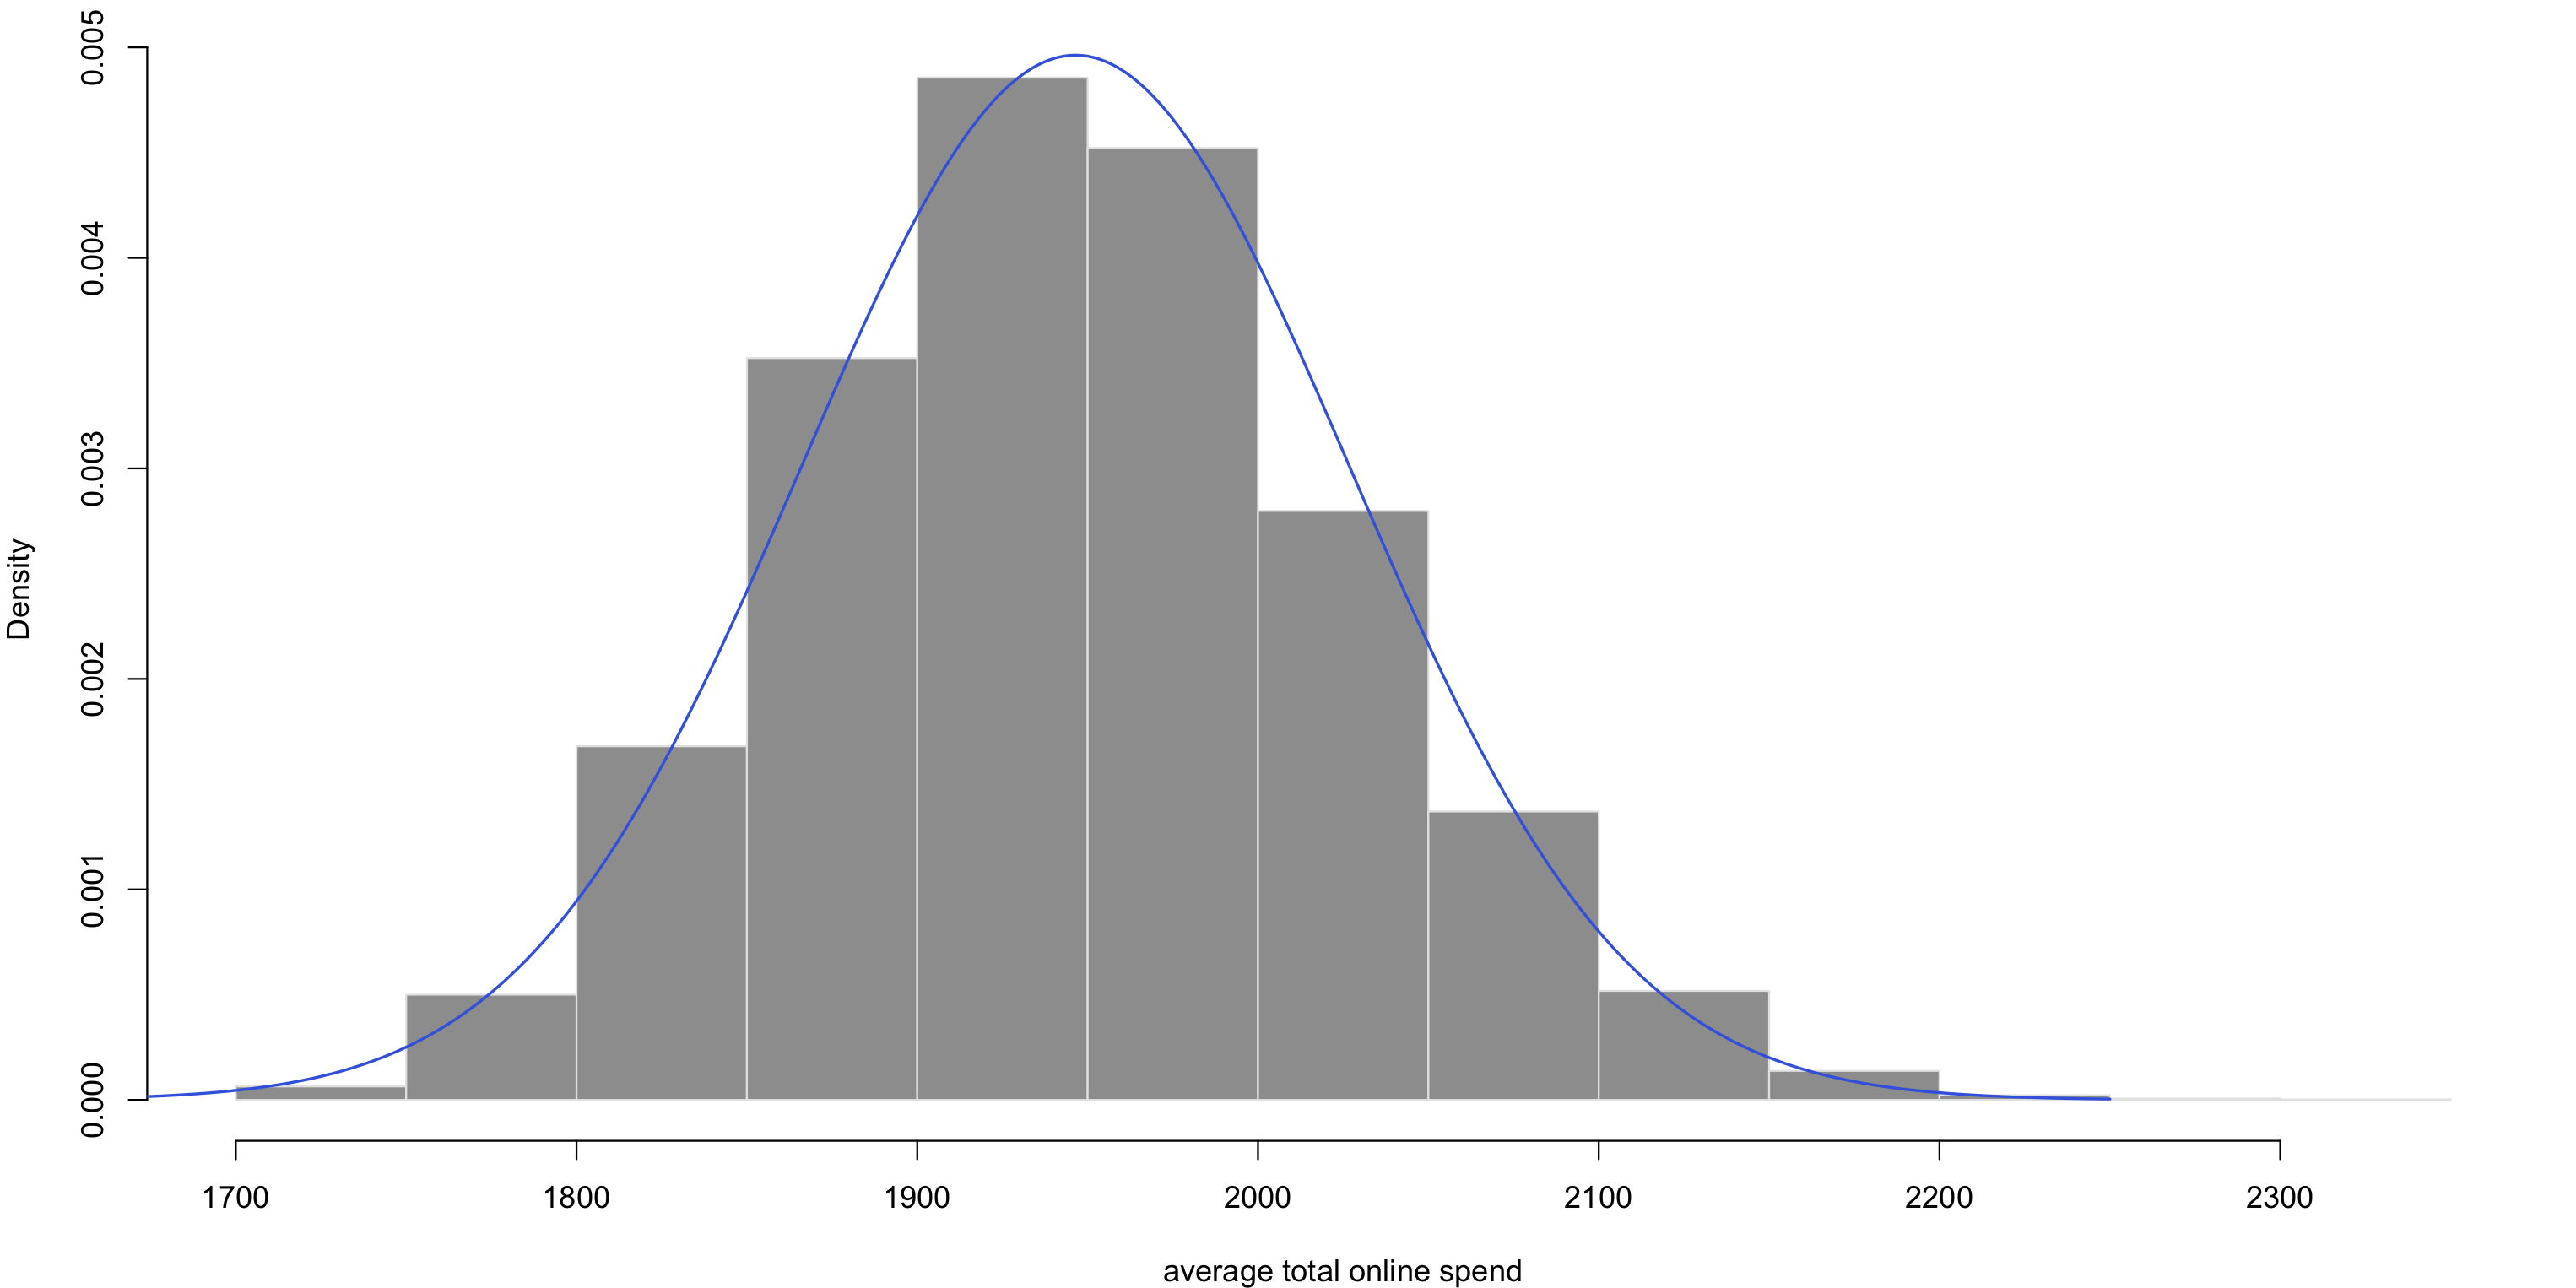

In [10]:
par(mai=c(.8,.8,.2,.2))
hist(mub, main="", xlab="average total online spend", 
	col=8, border="grey90", freq=FALSE)
lines(xx, dnorm(xx, xbar, xbse), col="royalblue", lwd=1.5)

A parametric bootstrap does something different: it generates the sample from the distribution we expect (see the parameters and the distribution here). In simple cases, it is not very surprising what we get back.

In [11]:
xbar <- mean(browser$spend)
sig2 <-  var(browser$spend)

B <- 10000
mus <- c()
for(b in 1:B){
  xsamp <- rnorm(1e4, xbar, sqrt(sig2))
  mus <- c(mus, mean(xsamp))
}

So what do you get?

In [12]:
sd(mus)
sqrt(sig2/1e4)

[1] 80.96422

[1] 80.3861

We can also remind ourselves that the sample variance is a biased estimate of the true population variance: compare a small sample (with sizable bias) to a large one (approximating the population).

To be honest, the book is lucky with the sample in print. For such a small sample, you can easily get one with a particularly large or small sample variance, nothing close to 99% ( (100-1)/100 ) of the "true" one. So you either do a Monte Carlo simulation averaging many random samples, or just take our word for it.

In [13]:
smallsamp <- browser$spend[sample.int(nrow(browser),100)]
s <- sd(smallsamp) # sample variance
s
sd(browser$spend)
s/sd(browser$spend)

[1] 9859.743

[1] 8038.61

[1] 1.226548

It is more important that bootstrap confidence intervals can also correct for bias in the estimates. So you can collect the deviation of the sample variance of many of these samples from our single estimate above.

In [14]:
eb <- c()
for (b in 1:B){
	sb <- sd(smallsamp[sample.int(100, replace=TRUE)]) 
	eb <- c(eb, sb-s)
}

This will not be centered around zero. But if you take extreme values from the tails of its distribution (e.g. 5% and 95%) and subtract those from your original estimate, you subtract the bias as well and should get back a 10% bootstrap confidence for the number you were after, here the population variance. See how we flip the bootstrap quantiles when we subtract them from the point estimate -- the top extreme will give you the lower end of your confidence interval, and vice versa. Make sure you remember why.

Though again, focus on the principle and not the particular example. If you have a horribly extreme small sample first and not for your bootstrap samples, in practice the bootstrap samples would not be equally biased and you might not correct the original estimate.

In [15]:
mean(eb)
tvals <- quantile(eb, c(0.05, 0.95))
tvals
s-tvals[2:1]

[1] -828.1336

5%       95% 
-8047.945  4733.090

95%        5% 
 5126.653 17907.687

Also remember why the sample means have one hundredth of the standard deviation of the standard deviation of raw data itself. (Here we had a large sample of 10000, the square root of which is 100.) This is why it is better to distinguish the sampling noise of the such estimates by calling them standard errors.

In [16]:
sd(mub)*100

[1] 8013.013

## Uncertainty and bootstrap of regressions

We skipped a bit in the book that starts with regressions only to get back to those models in earnest later.

Let's start with a linear model of log spending in the same browser data, using two explanatory variables.

In [17]:
summary( glm( log(spend) ~ broadband + anychildren, data=browser) )


Call:
glm(formula = log(spend) ~ broadband + anychildren, data = browser)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.2379  -1.0787   0.0349   1.1292   6.5825  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.68508    0.04403 129.119   <2e-16 ***
broadband    0.55285    0.04357  12.689   <2e-16 ***
anychildren  0.08216    0.03380   2.431   0.0151 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 2.737459)

    Null deviance: 27828  on 9999  degrees of freedom
Residual deviance: 27366  on 9997  degrees of freedom
AIC: 38454

Number of Fisher Scoring iterations: 2


Once again, we were promised that the standard errors on the coefficients will describe the sampling variation of these estimates, but with modern (i.e., younger than 50 years) computers we can also just simulate what that means. Again, this is a nonparametric bootstrap.

In [18]:
B <- 1000
betas <- c()
for (b in 1:B){
	samp_b = sample.int(nrow(browser), replace=TRUE)
	reg_b <- glm(log(spend) ~ broadband + anychildren, data=browser[samp_b,])
	betas <- rbind(betas, coef(reg_b))
}
head(betas)

(Intercept),broadband,anychildren
5.661891,0.5699455,0.09422068
5.697375,0.5573944,0.08023226
5.671598,0.5885524,0.03134885
5.704700,0.5756452,0.06560389
5.715690,0.5223223,0.03383017
5.646830,0.6011626,0.02183567


So we collected many of these esimates. We can check whether the two coefficients seem to be correlated (this is not trivial to see from the standard regression output based on asymptotic theory, though you also want to be careful whether the bootstrap is always capable of estimating these "higher-order" objects like interactions very well).

We can also calculate a normal density (with mean and standard deviation from the original regression table) for 100 equally distributed points between the minimal and maximal `broadband` coefficients among the bootstrap samples, so we can overlay the curve and the histogram.

[1] -0.005917825

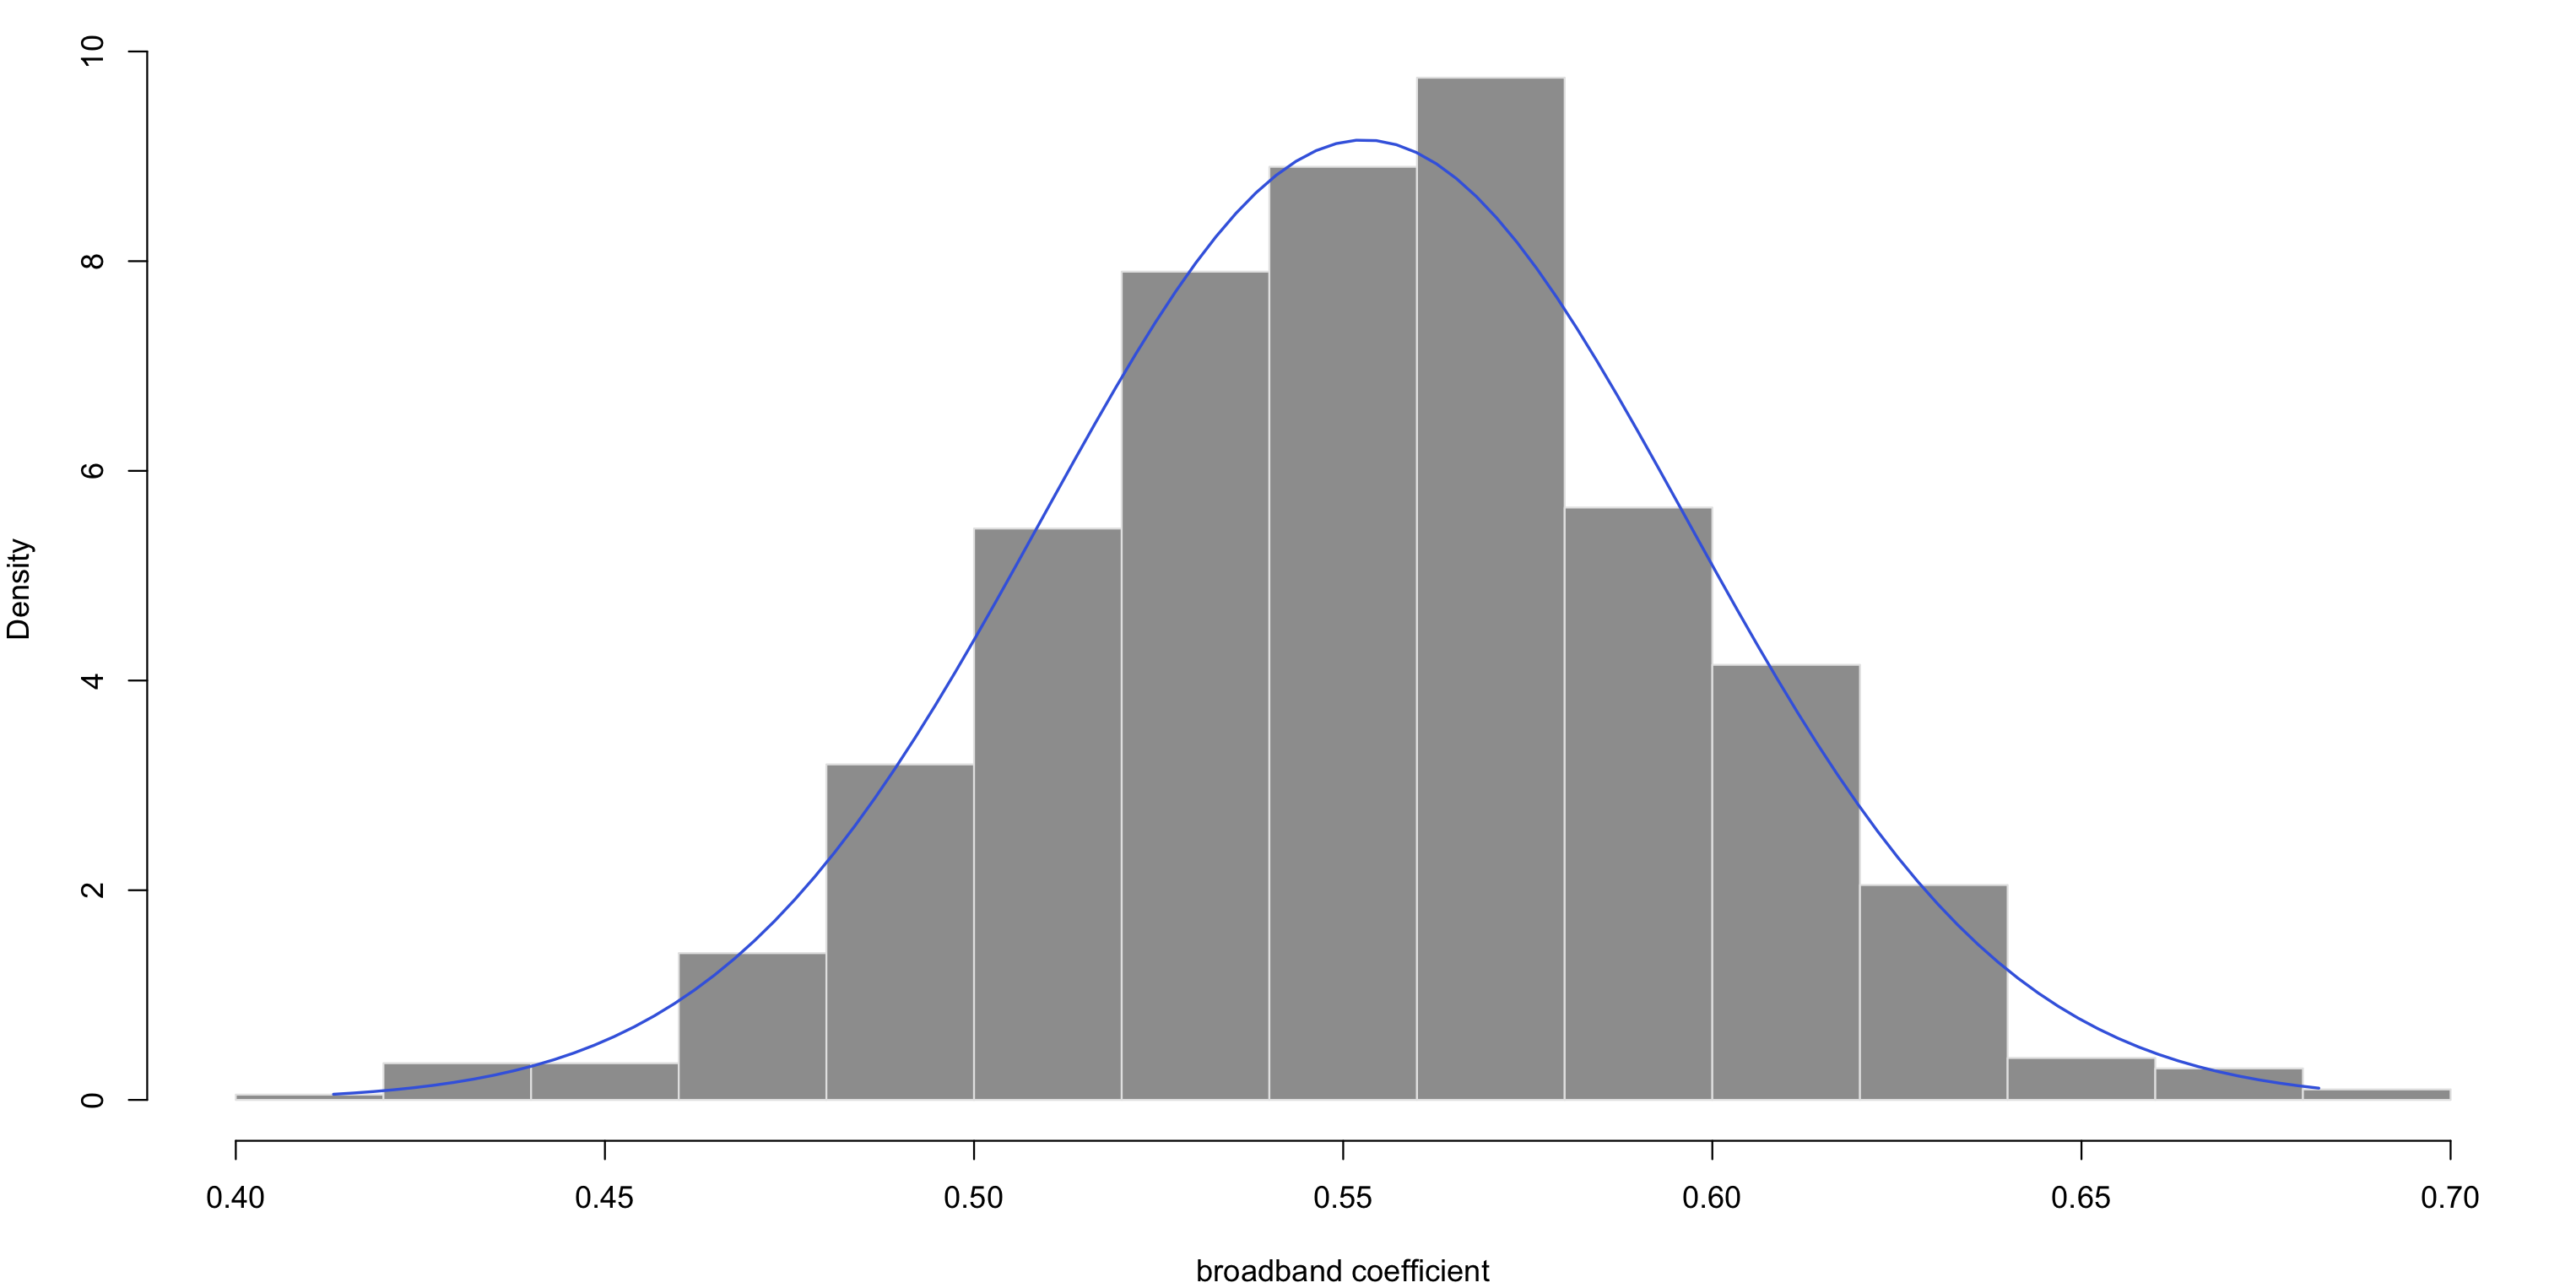

In [19]:
cor(betas[,"broadband"], betas[,"anychildren"])

xx <- seq(min(betas[,2]),max(betas[,2]),length=100)

par(mai=c(.8,.8,.2,.2))
hist(betas[,2], main="", xlab="broadband coefficient", 
	col=8, border="grey90", freq=FALSE)
lines(xx, dnorm(xx, 0.55285, 0.04357), col="royalblue", lwd=1.5)

Because we estimated a log model, the coefficients can be interpreted as multipliers of the original `spend` variable. Of course, if the raw coefficient has a normal sampling distribution, the multipliers (its exponential transforms) will have a log-normal.

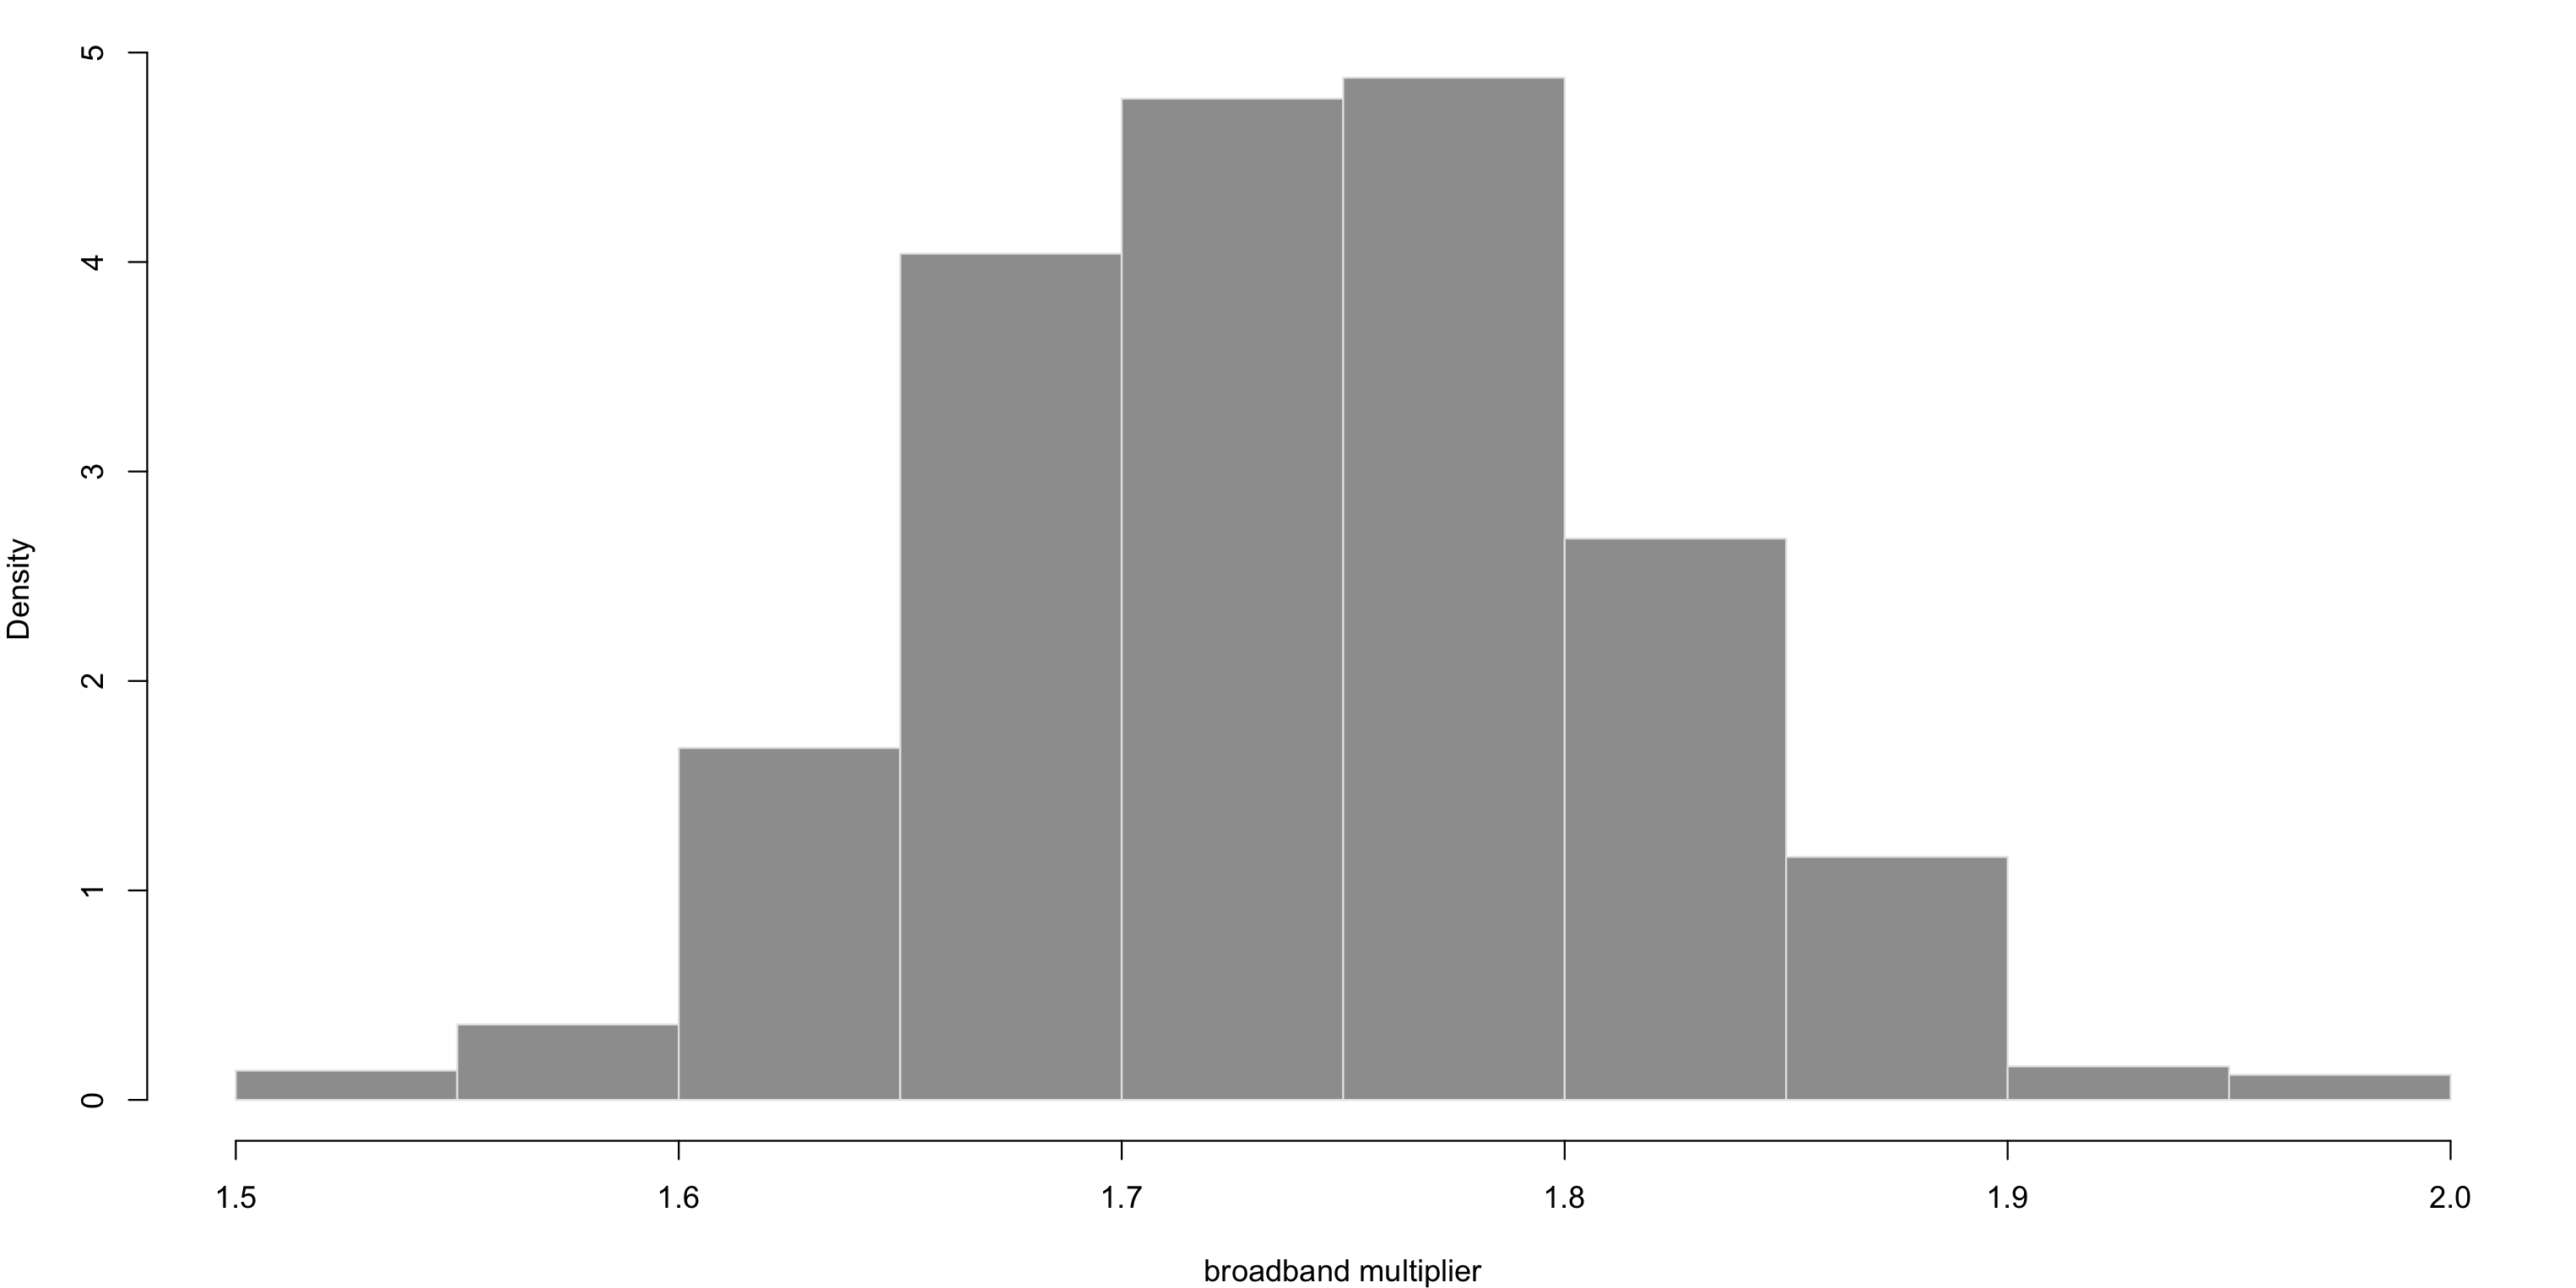

In [20]:
par(mai=c(.8,.8,.2,.2))
hist(exp(betas[,2]), main="", xlab="broadband multiplier", 
	col=8, border="grey90", freq=FALSE)

Of course, you can also estimate more complicated models, maybe using all variables in the dataframe but the explanatory variable (with the `.` shorthand) or exclude some variables from it (using the `-` shorthand). You can also manipulate the output, for instance the `coef` table of the model object storing coefficients, their standard errors, t-values and p-values; for instance, you can round the numbers to two digits. Finally, we can learn and easy shortcut to store the p-values (a column of the table), maybe leaving the first row out if we do not want to confuse ourselves with the intercept.

In [21]:
spendy <- glm( log(spend) ~ .-id, data=browser) 
round(summary(spendy)$coef,2)
pval <- summary(spendy)$coef[-1,"Pr(>|t|)"]

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),5.86,0.16,36.34,0.00
anychildren,0.09,0.03,2.54,0.01
broadband,0.52,0.04,11.93,0.00
hispanic,-0.18,0.04,-4.30,0.00
raceblack,-0.25,0.18,-1.41,0.16
raceother,-0.41,0.31,-1.32,0.19
racewhite,-0.21,0.15,-1.36,0.17
regionNE,0.26,0.05,4.98,0.00
regionS,0.01,0.04,0.13,0.90
regionW,0.18,0.05,3.47,0.00


Using the Benjamini-Hochberg logic, we know to focus on the smallest p-values that are below the line that would be implied by the targeted False Discovery Rate (here 10%) and the number of variables (here 9). There is a simple bounding exercise in the proof of Figure 1.12 to argue why only so many false discoveries with uniformly distributed p-values will below this line if you focus on the smallest p-values. As long as we pick the smallest ones below the line, in expectation we only have as many false discoveries as we targeted. Remember, we can never be sure that we did not get unlucky with an insignificant variable having an extreme low p-value in our sample that 'cuts the line' and shows up among the smallest one, with a true discovery being bumped up above the line.

Now we can plot the p-values in ascending order, then the line, and yet again plot the p-values that our under the line to make them have a different color. (This is done manually here that we see that the first five ones are below.)

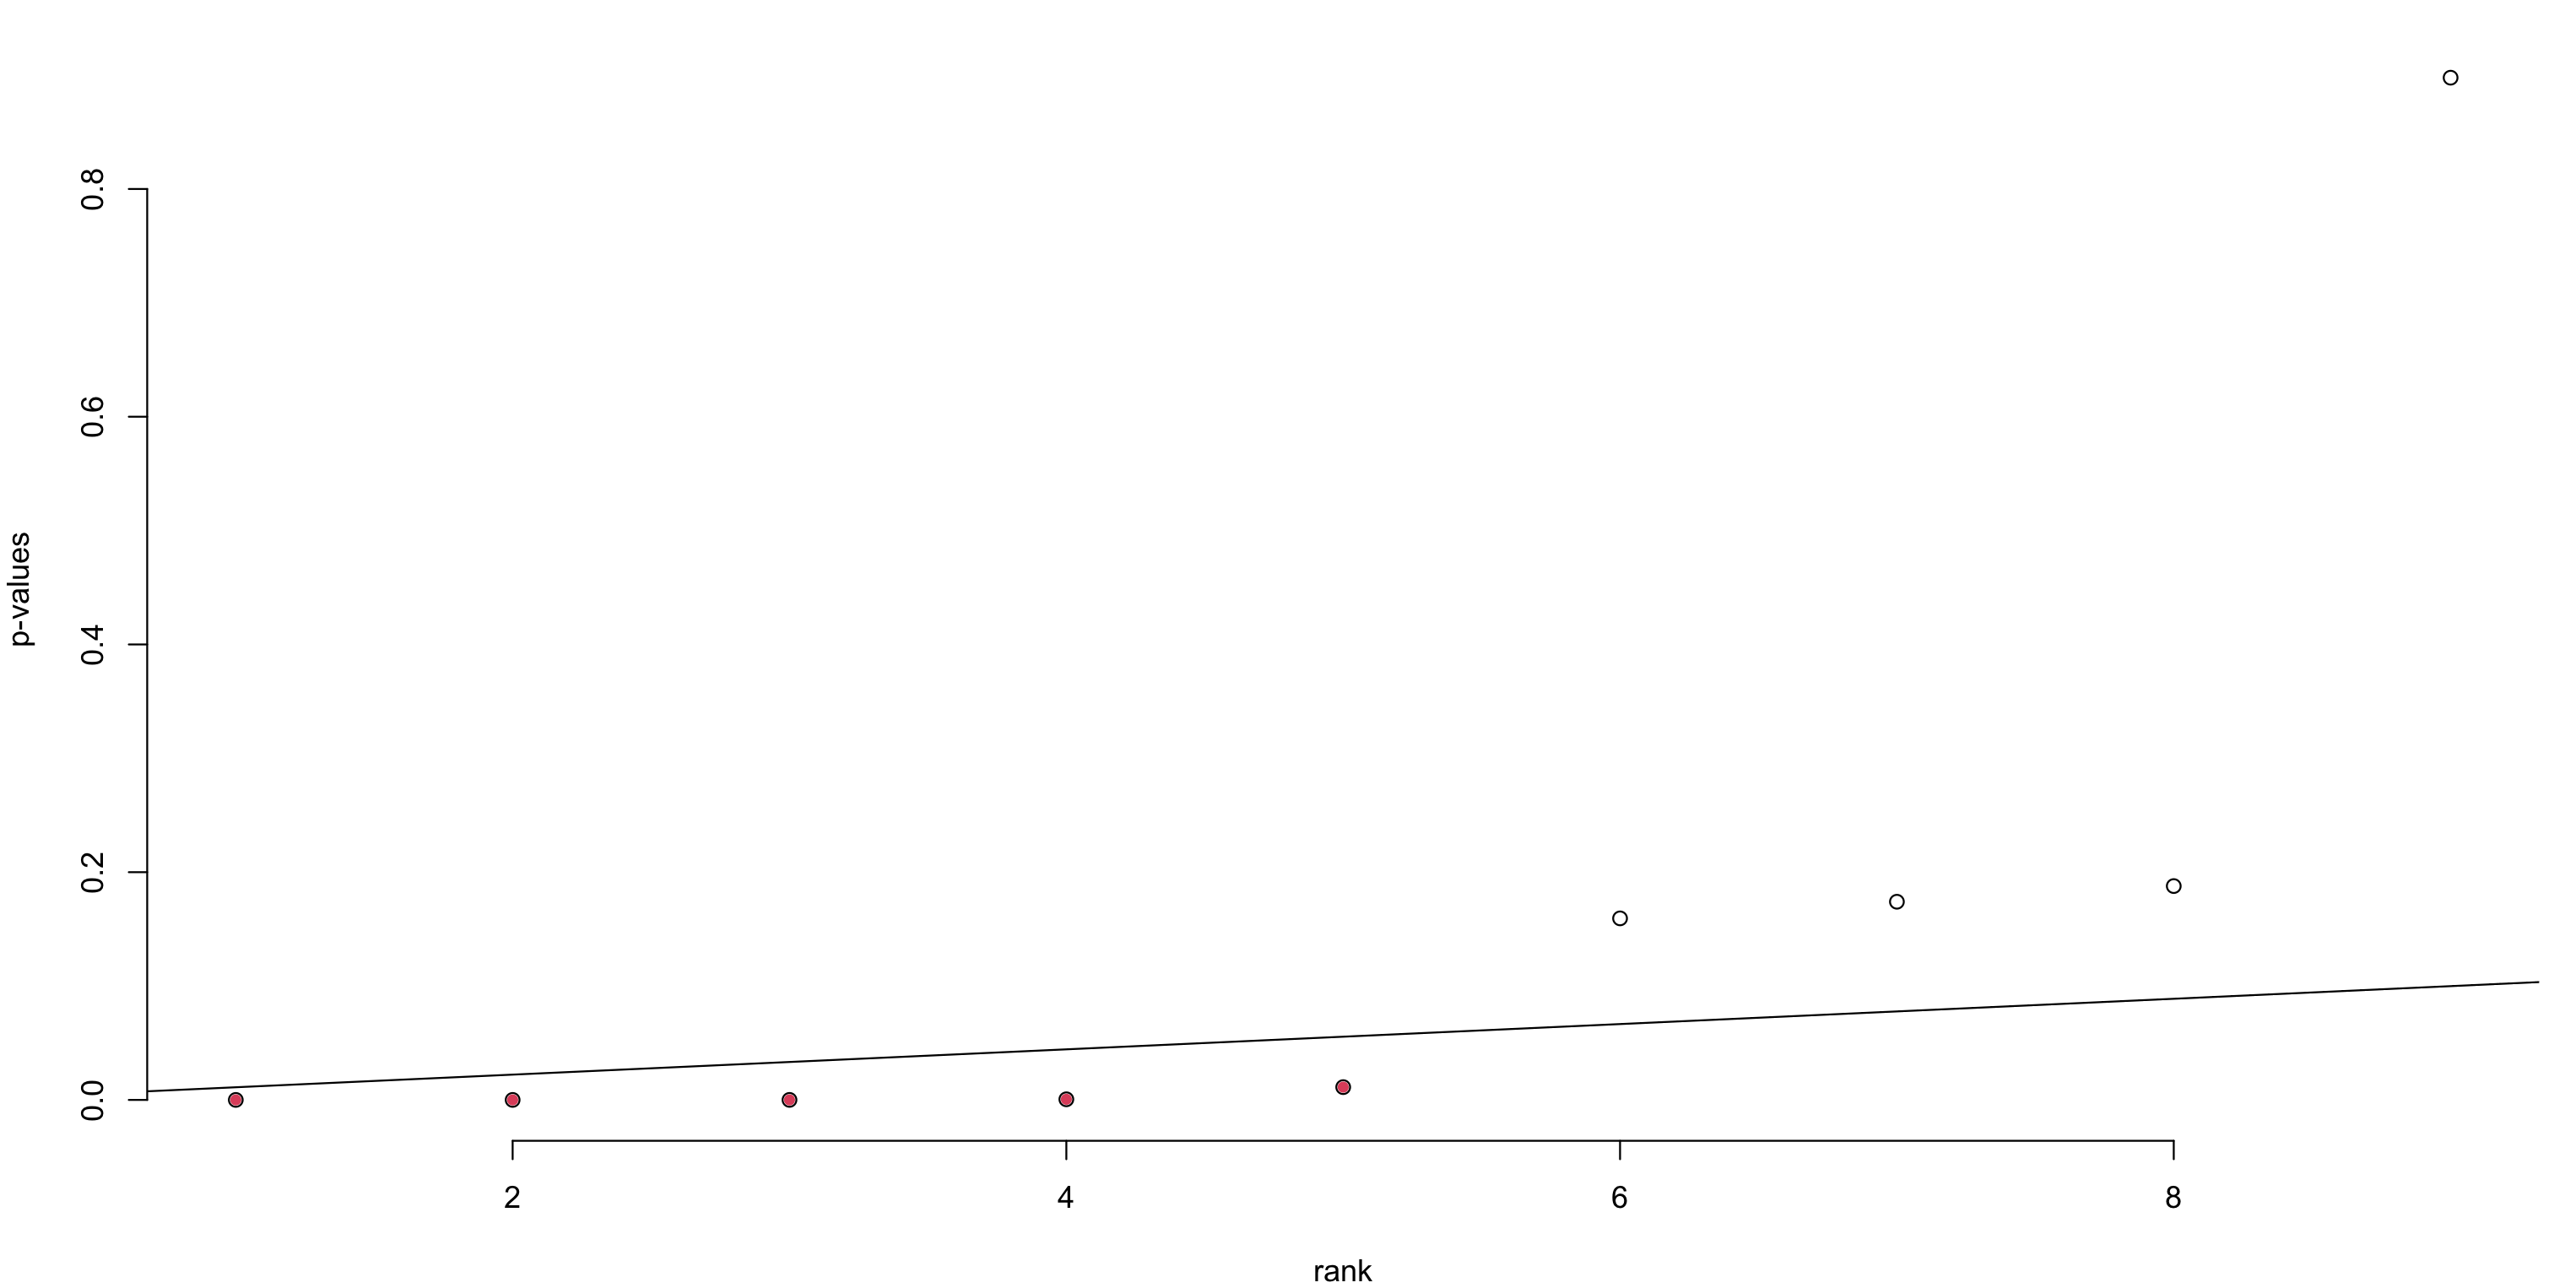

In [22]:
par(mai=c(.8,.8,.2,.2))
plot(sort(pval), bty="n", xlab="rank", ylab="p-values")
abline(a=0, b=.1/9)
points(sort(pval)[1:5], col=2, pch=20)

Just to reproduce the book, we can plot the trivial density function of a uniform distribution.

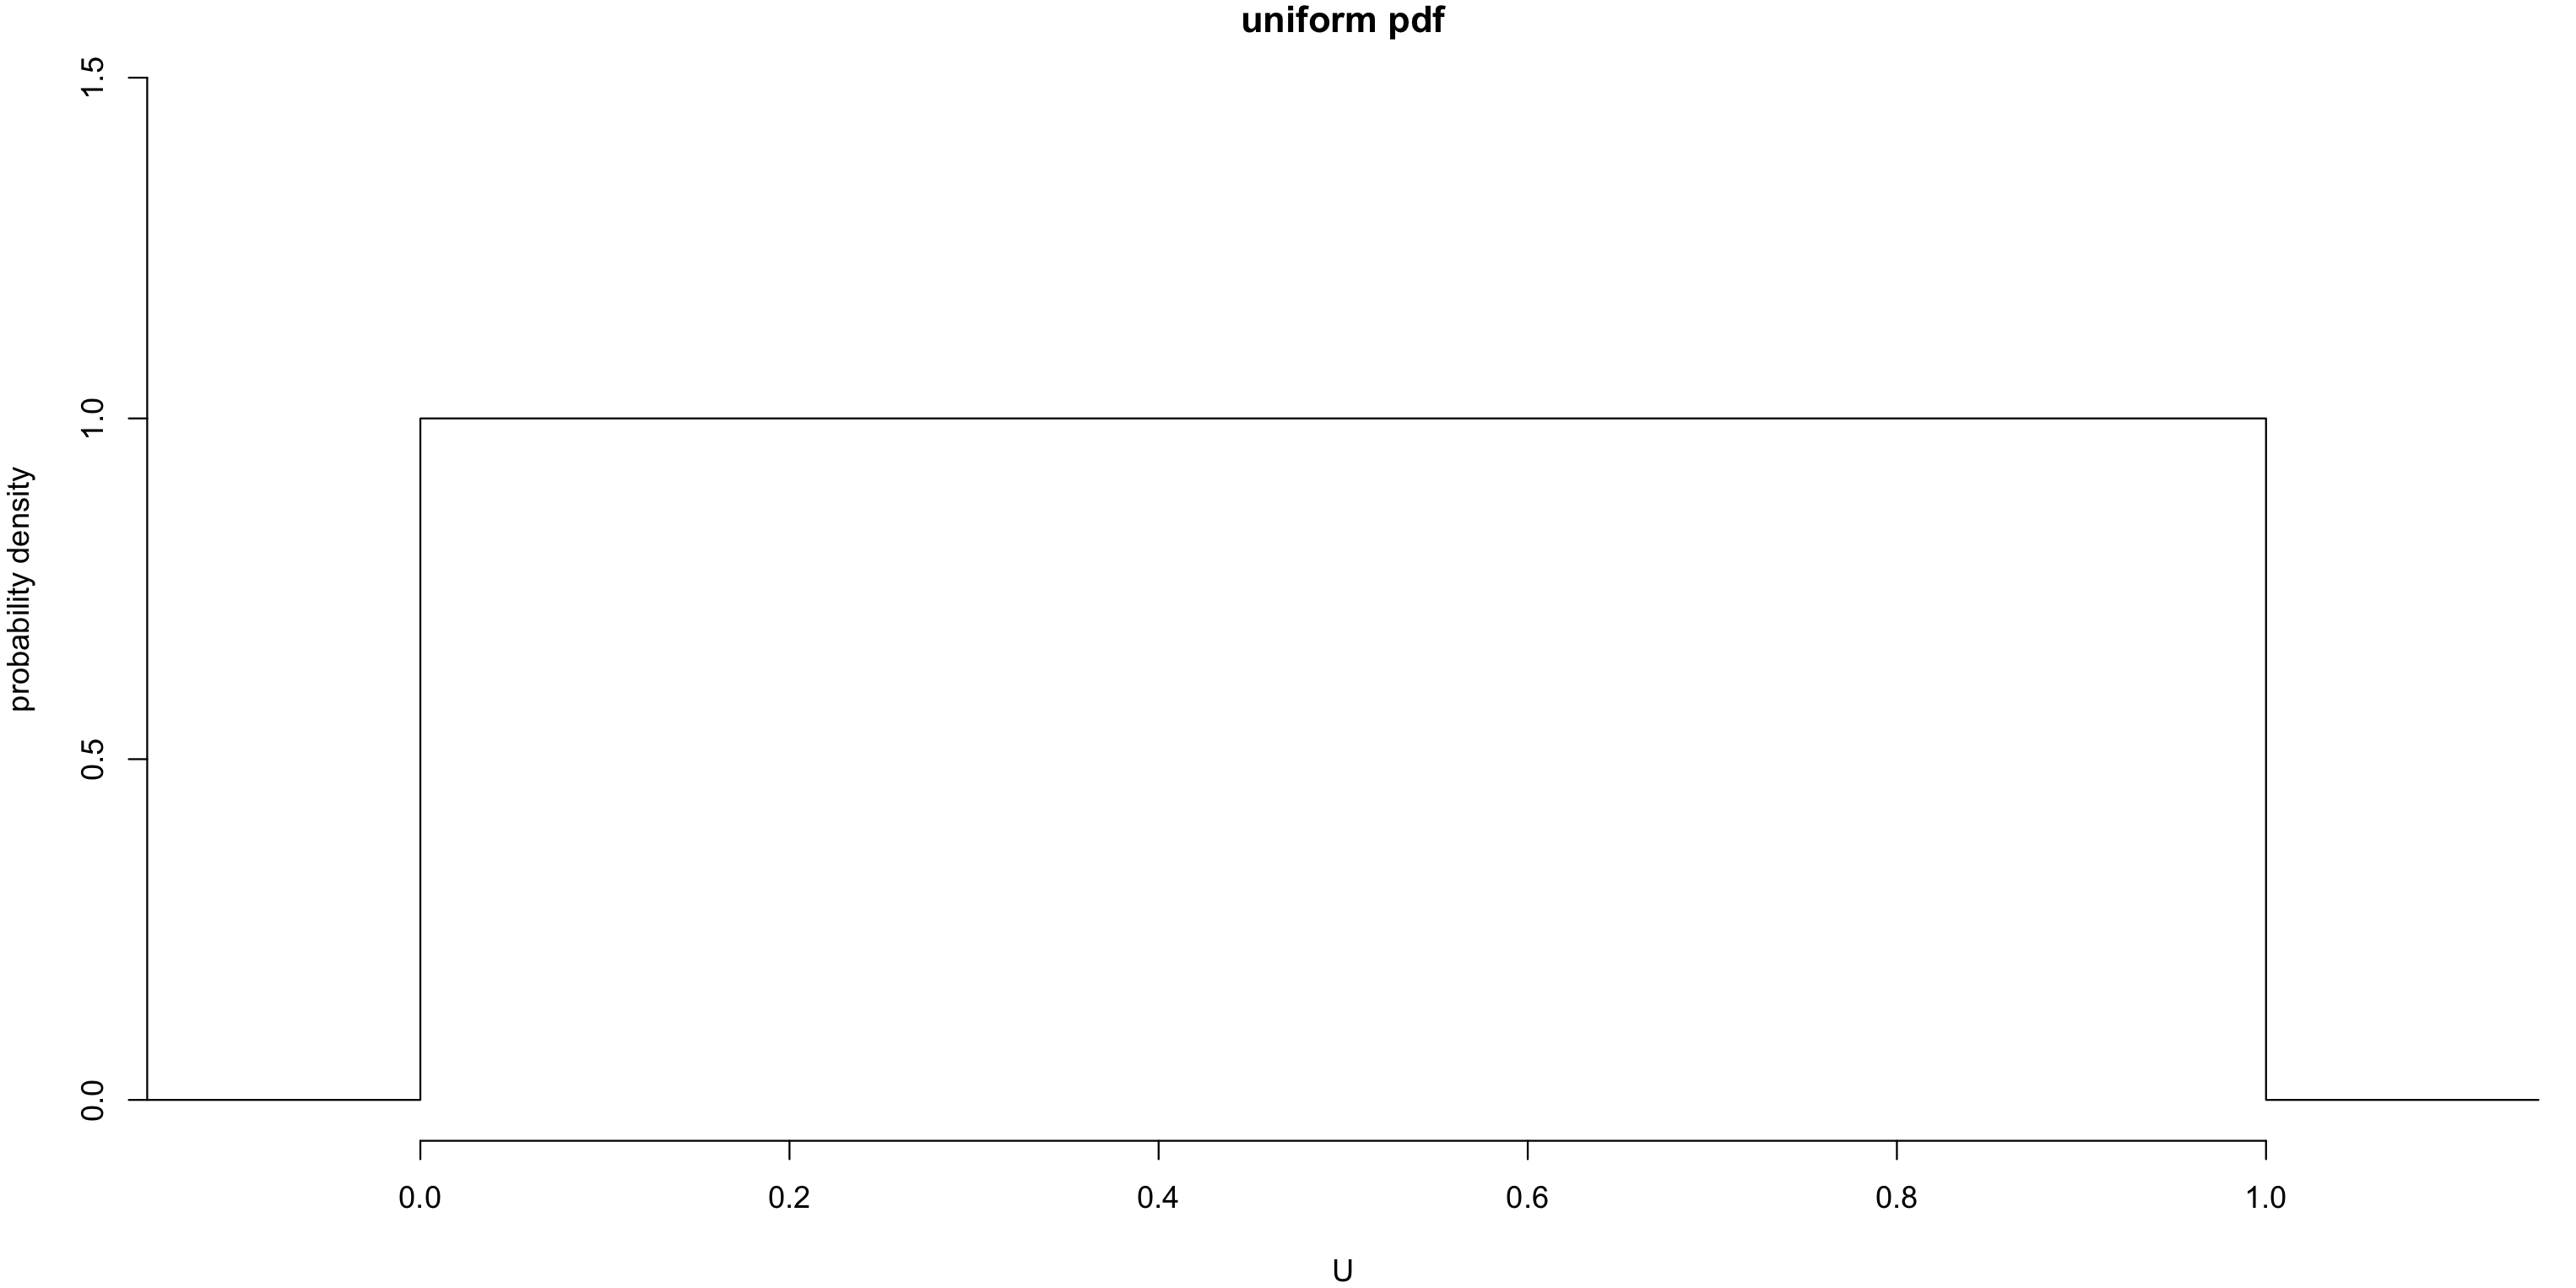

In [23]:
par(mai=c(.8,.8,.2,.2))
plot(c(-1,0,0,1,1,2), c(0,0,1,1,0,0), ylim=c(0,1.5), xlim=c(-0.1,1.1),
	type="l", bty="n", xlab="U", ylab="probability density", main = "uniform pdf")

Under the null hypothesis of all variables being insignificant and thus their p-values being uniformly distributed, their ranked and ordered list should follow a line of slope 1/(N+1), or here 1/10. We can also plot this line against the actual distribution of our p-values to see what our actual true discoveries do to ranked list of p-values.

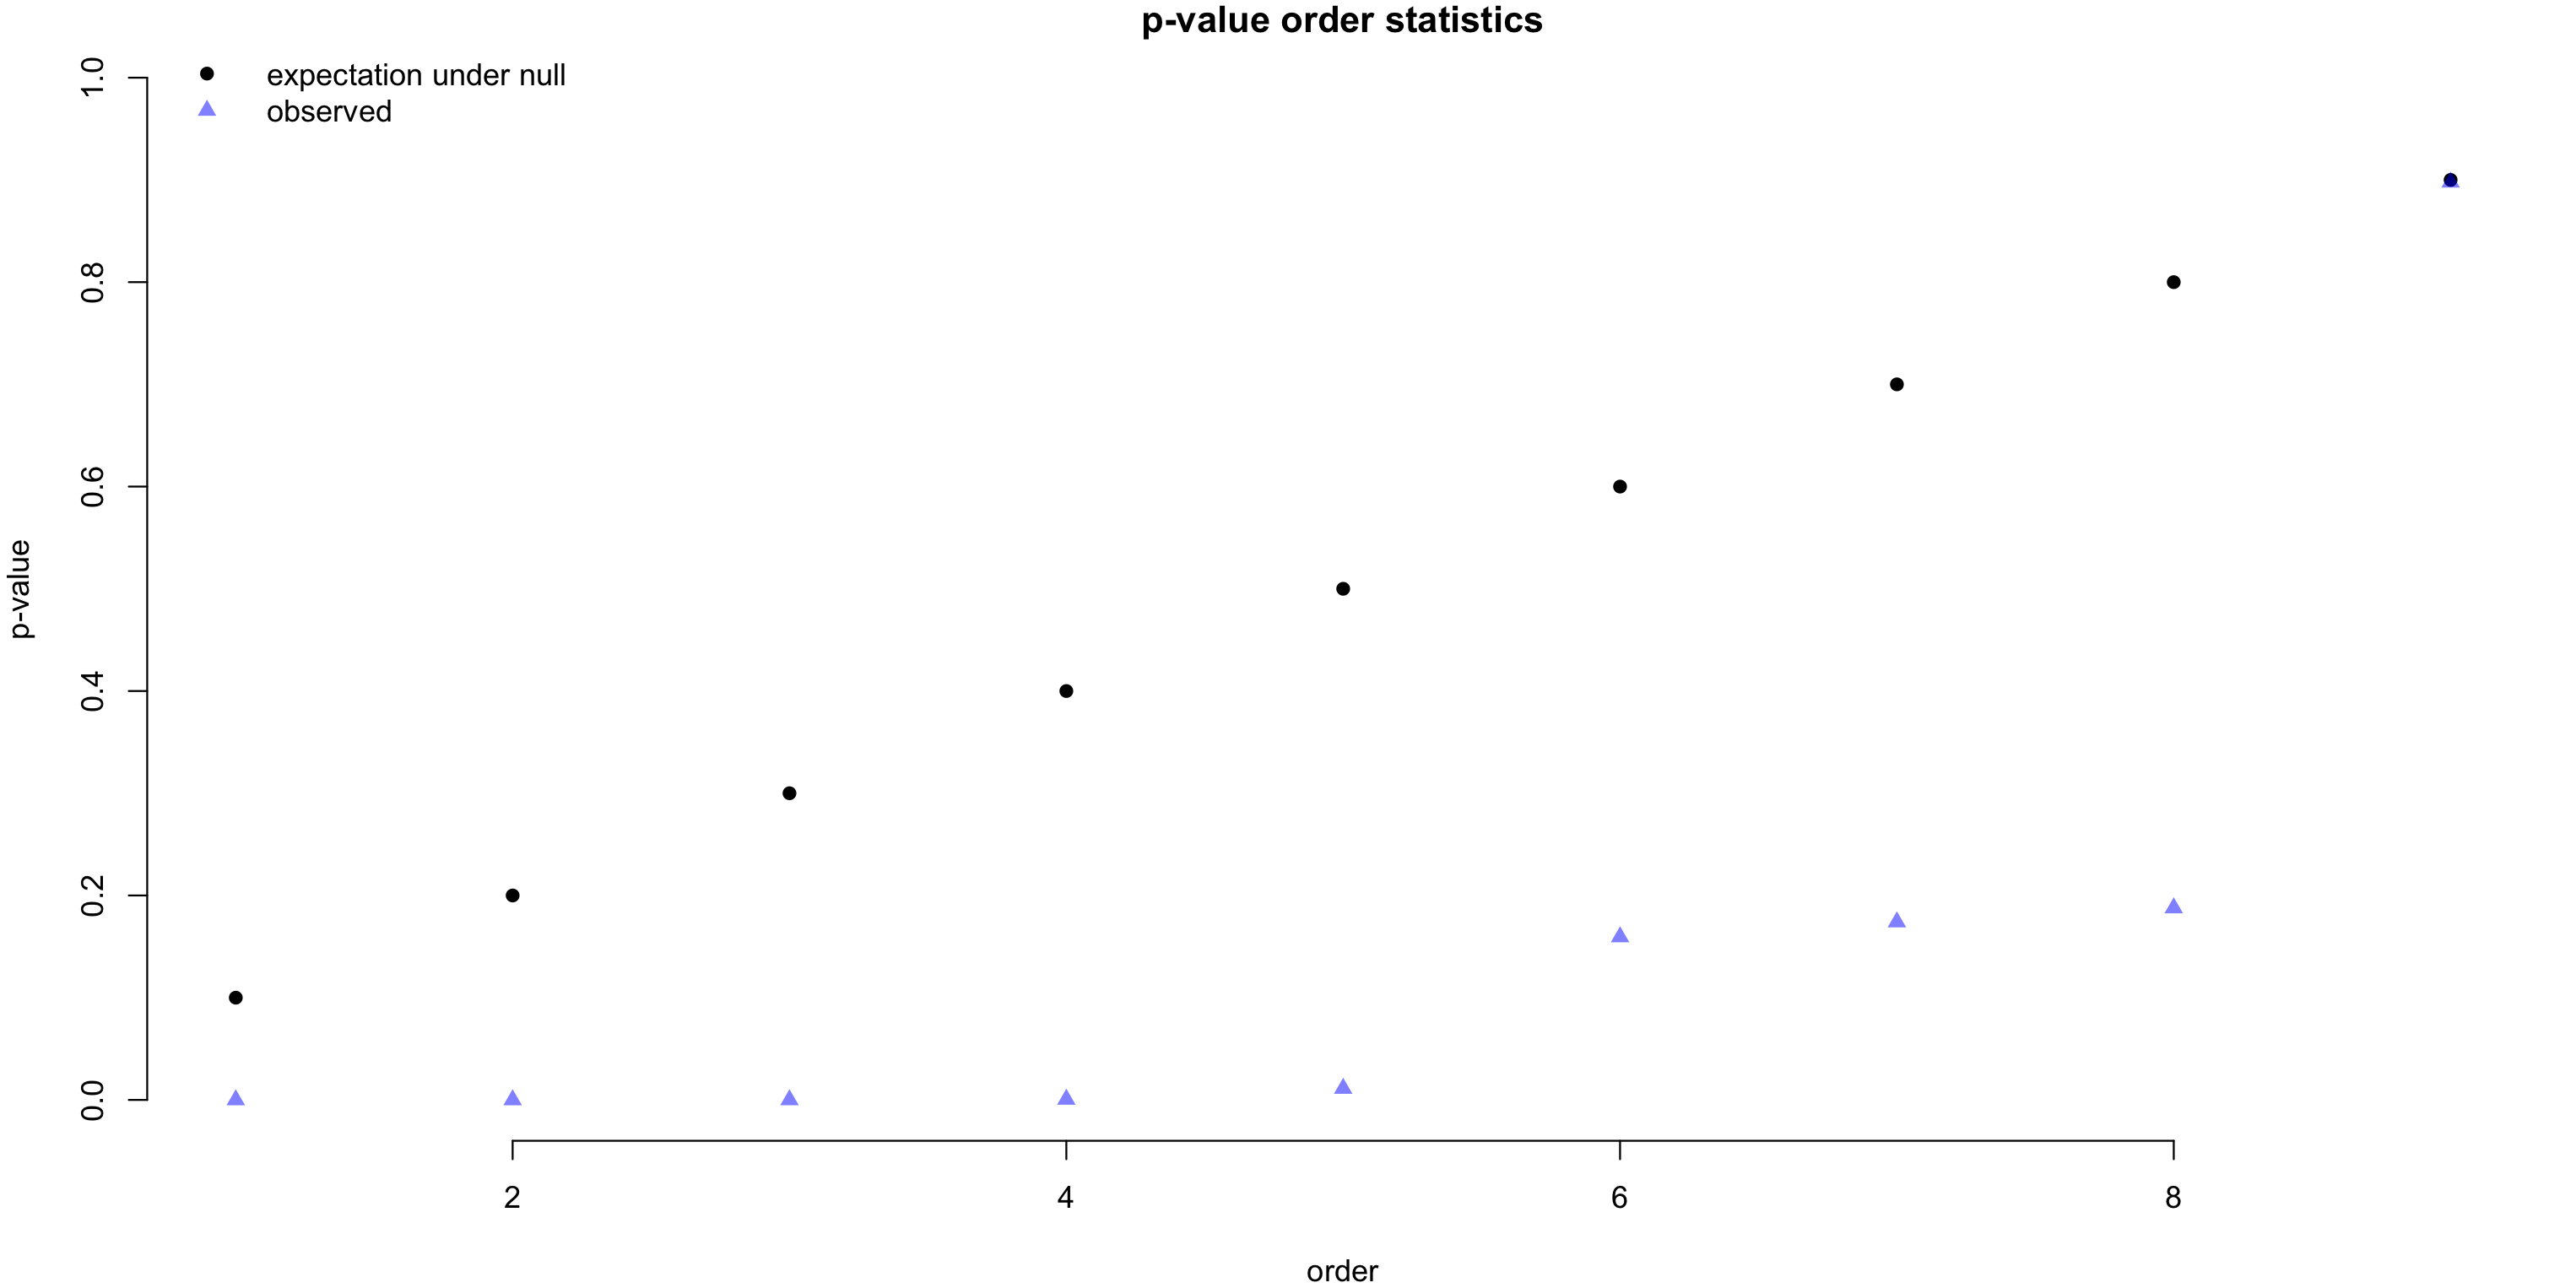

In [24]:
par(mai=c(.8,.8,.2,.2))
plot(1:9, (1:9)/10, ylim=c(0,1),
	pch=16, col="black", bty="n", ylab="p-value", 
	xlab="order", main = "p-value order statistics")
points(1:9, sort(pval), pch=17, col=rgb(0,0,1,.5))
legend("topleft", bty="n",
	legend=c("expectation under null","observed"), pch=c(16,17),
	col=c("black",rgb(0,0,1,.5)))

## Genetic example for extreme false discovery rates

This example uses a non-standard `R` package. `data.table` is useful for dealing with large datasets.

In [25]:
install.packages("data.table")
library(data.table)


The downloaded binary packages are in
	/var/folders/dk/2_0472cd7h35shgpvb9y6g6xp8980h/T//RtmpaKi8f6/downloaded_packages


Also, we can practice some tricks: `fread` reads the data in faster than `read.table` (we are timing it here), but then we also need to convert it back to a conventional `data.frame` (other good uses of it will come later).

Note that this data set is large, so it is not on GitHub. You can download it from https://grasp.nhlbi.nih.gov/downloads/ResultsOctober2016/Global_Lipids_Genetics_Consortium/jointGwasMc_LDL.txt.gz.

In [27]:
system.time(lipids <-  fread("jointGwasMc_LDL.txt"))
lipids <- as.data.frame(lipids)

   user  system elapsed 
 12.072   0.409  20.225 

This is a bit unusual, but this data came with p-values from Willer et al. So we just load them as a variable. Another column/variable has the corresponding names for the gene locations.

In [28]:
pvals <- as.numeric(lipids[,'P-value'])
names(pvals) <- lipids[,'rsid']

If we plot the p-value distribution, we can notice a tiny spike near zero.

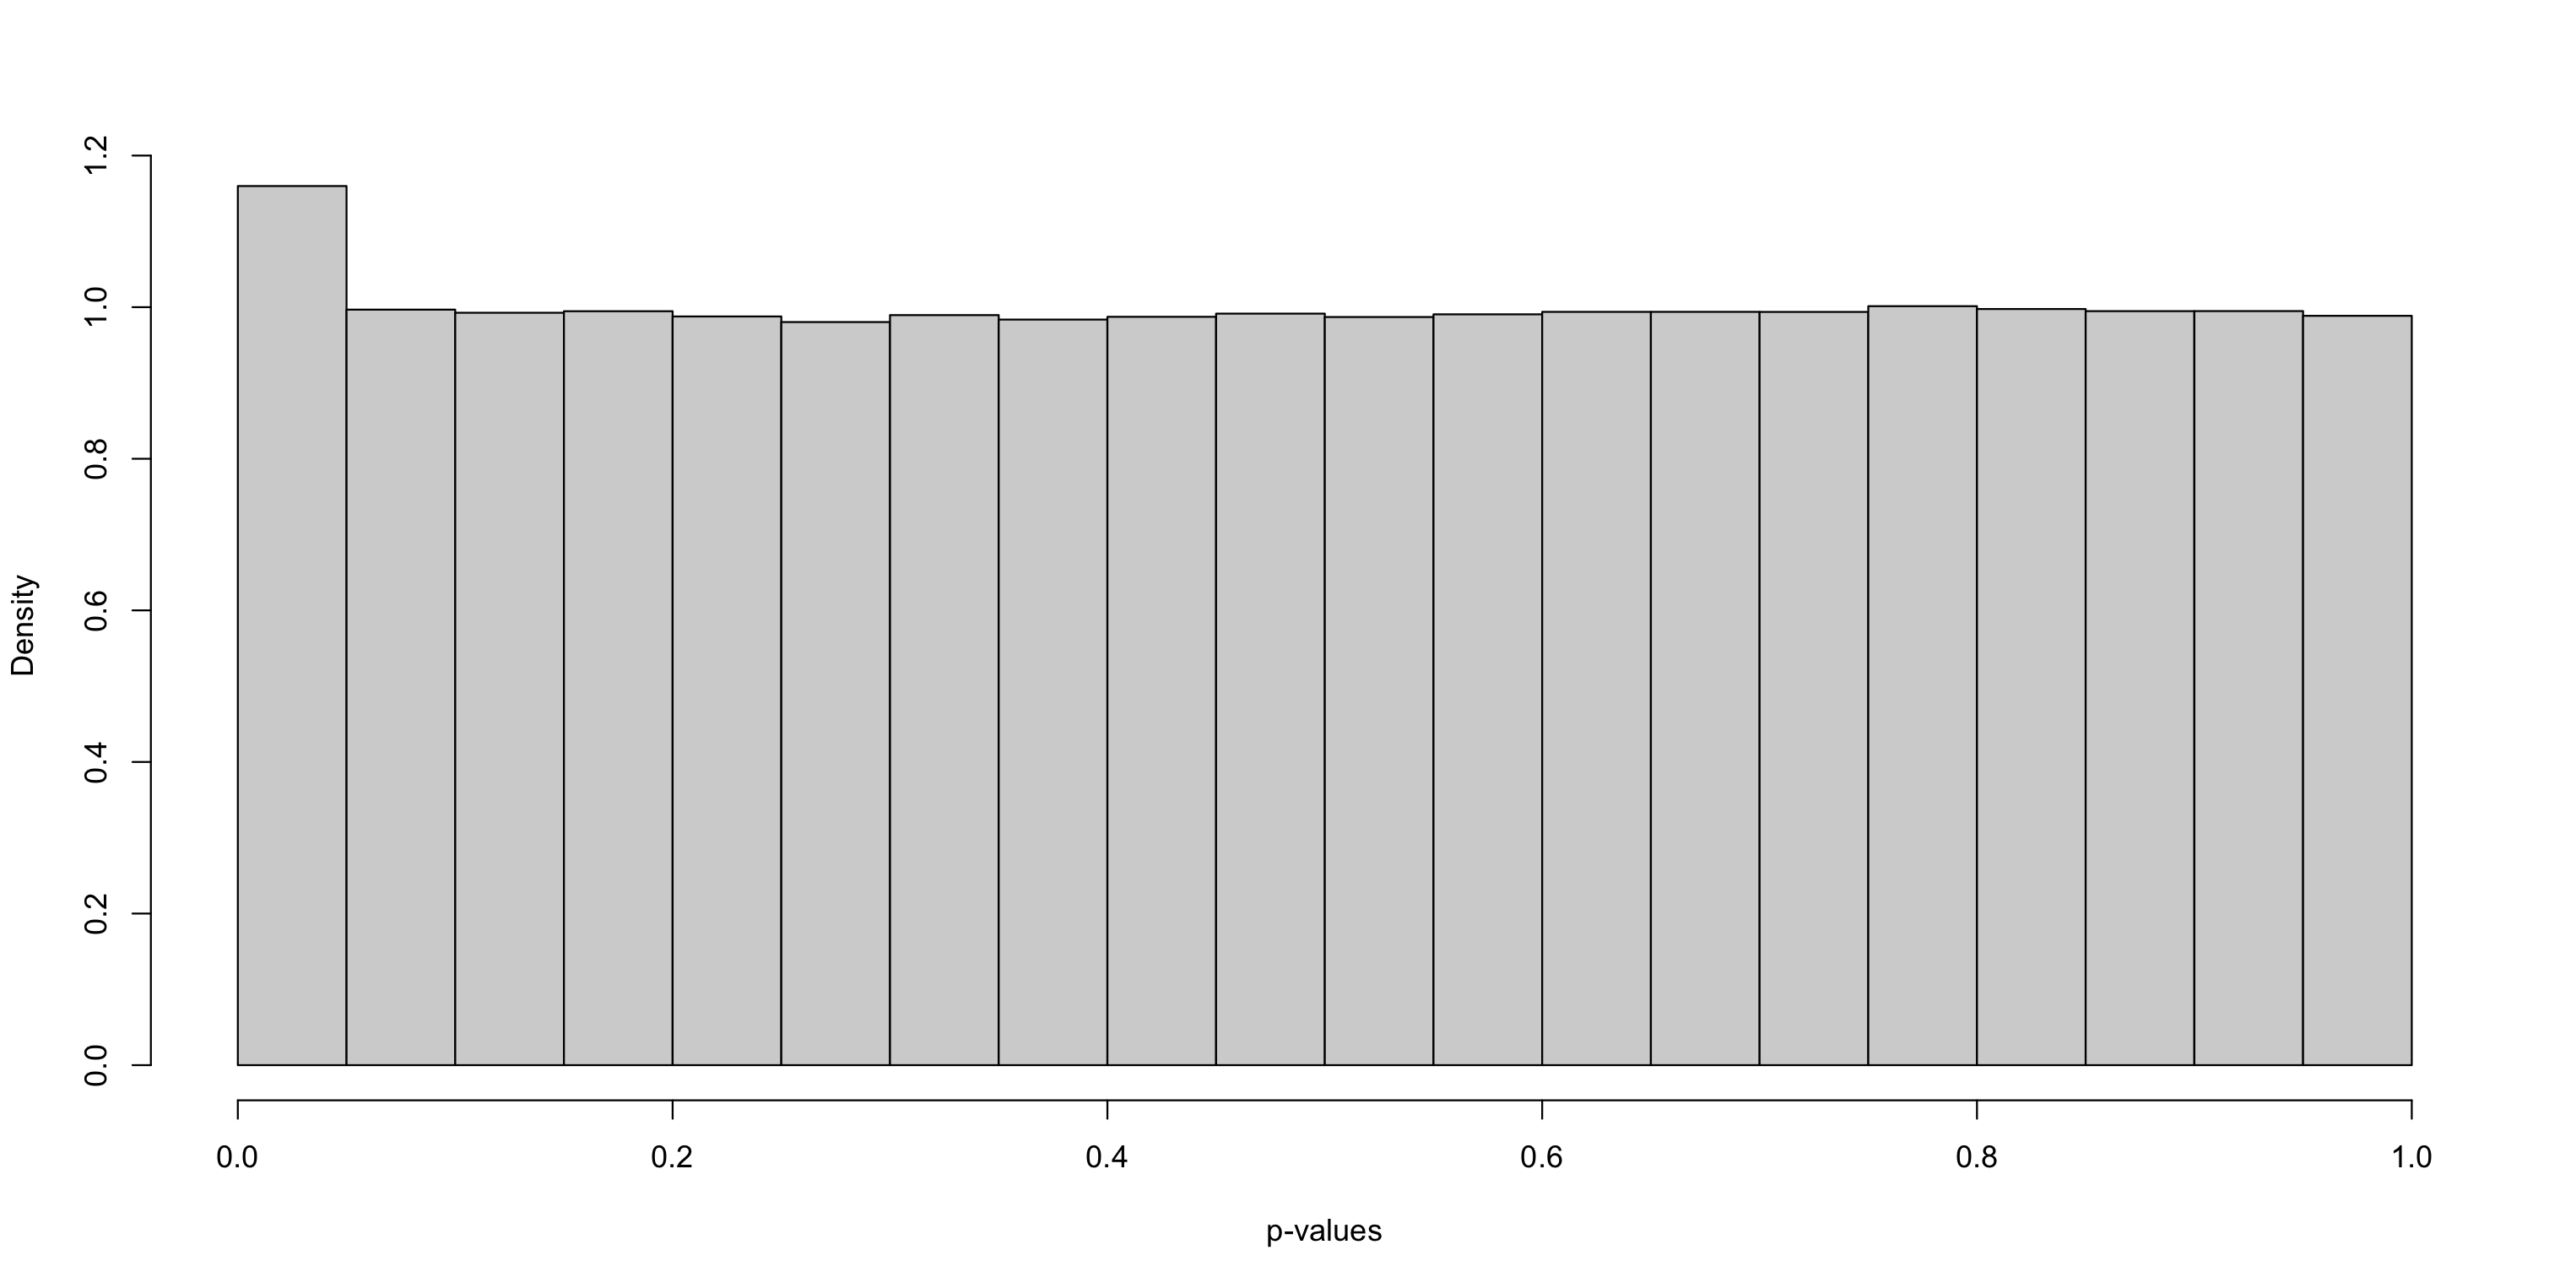

In [29]:
hist(pvals, main='', xlab='p-values',freq=FALSE) # freq=FALSE gives you a density plot

If you drug company had a budget for 10 genes only, you might want to focus on the ten locations with the smallest associated p-values.

In [30]:
names(pvals)[order(pvals)[1:10]] 

[1] "rs7254892"  "rs7412"     "rs445925"   "rs646776"   "rs12740374"
 [6] "rs599839"   "rs660240"   "rs6511720"  "rs602633"   "rs629301"

Here's a function to get significance cut-off alpha from FDR q using the Benjamini-Hochberg algorithm.This is what we also use in `fdr.R`. Try to understand what it does. The difficulty should be about R functions and how to carry on an output of one to another. In the end we just check the largest p-value that is below the line we talked about.

In [31]:
fdr_cut <- function(pvals, q){
  pvals <- pvals[!is.na(pvals)]
  N <- length(pvals)
  
  k <- rank(pvals, ties.method="min")
  alpha <- max(pvals[ pvals<= (q*k/N) ])
  
  return(alpha)
}

We can find the cut for different FDRs. First: 10% FDR. Here we print the cutoff as well as the number of variables that would pass this cutoff. Notice that you sum a binary (0-1) variable you basically calculate the 1s.

In [32]:
cutoff10 <- fdr_cut(pvals,q=.1)
print(cutoff10)
print(sum(pvals<=cutoff10))

[1] 0.0003988
[1] 9723


Same for 1% FDR:

In [33]:
cutoff1 <- fdr_cut(pvals,q=.01)
print(cutoff1)
print(sum(pvals<=cutoff1))

[1] 2.397e-05
[1] 5851


Targeting a one-tenth of percent FDR, you get 4000 discoveries, only 4-5 of which you expect to be false:

In [34]:
cutoff01 <- fdr_cut(pvals,q=.001)
print(cutoff01)
print(sum(pvals<=cutoff01))

[1] 1.702e-06
[1] 4158


In `fdr.R`, you might have also seen the code to visualize the B+H FDR algorithm (though for this many variables, the plot can take a bit of time and memory).

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“3 y values <= 0 omitted from logarithmic plot”


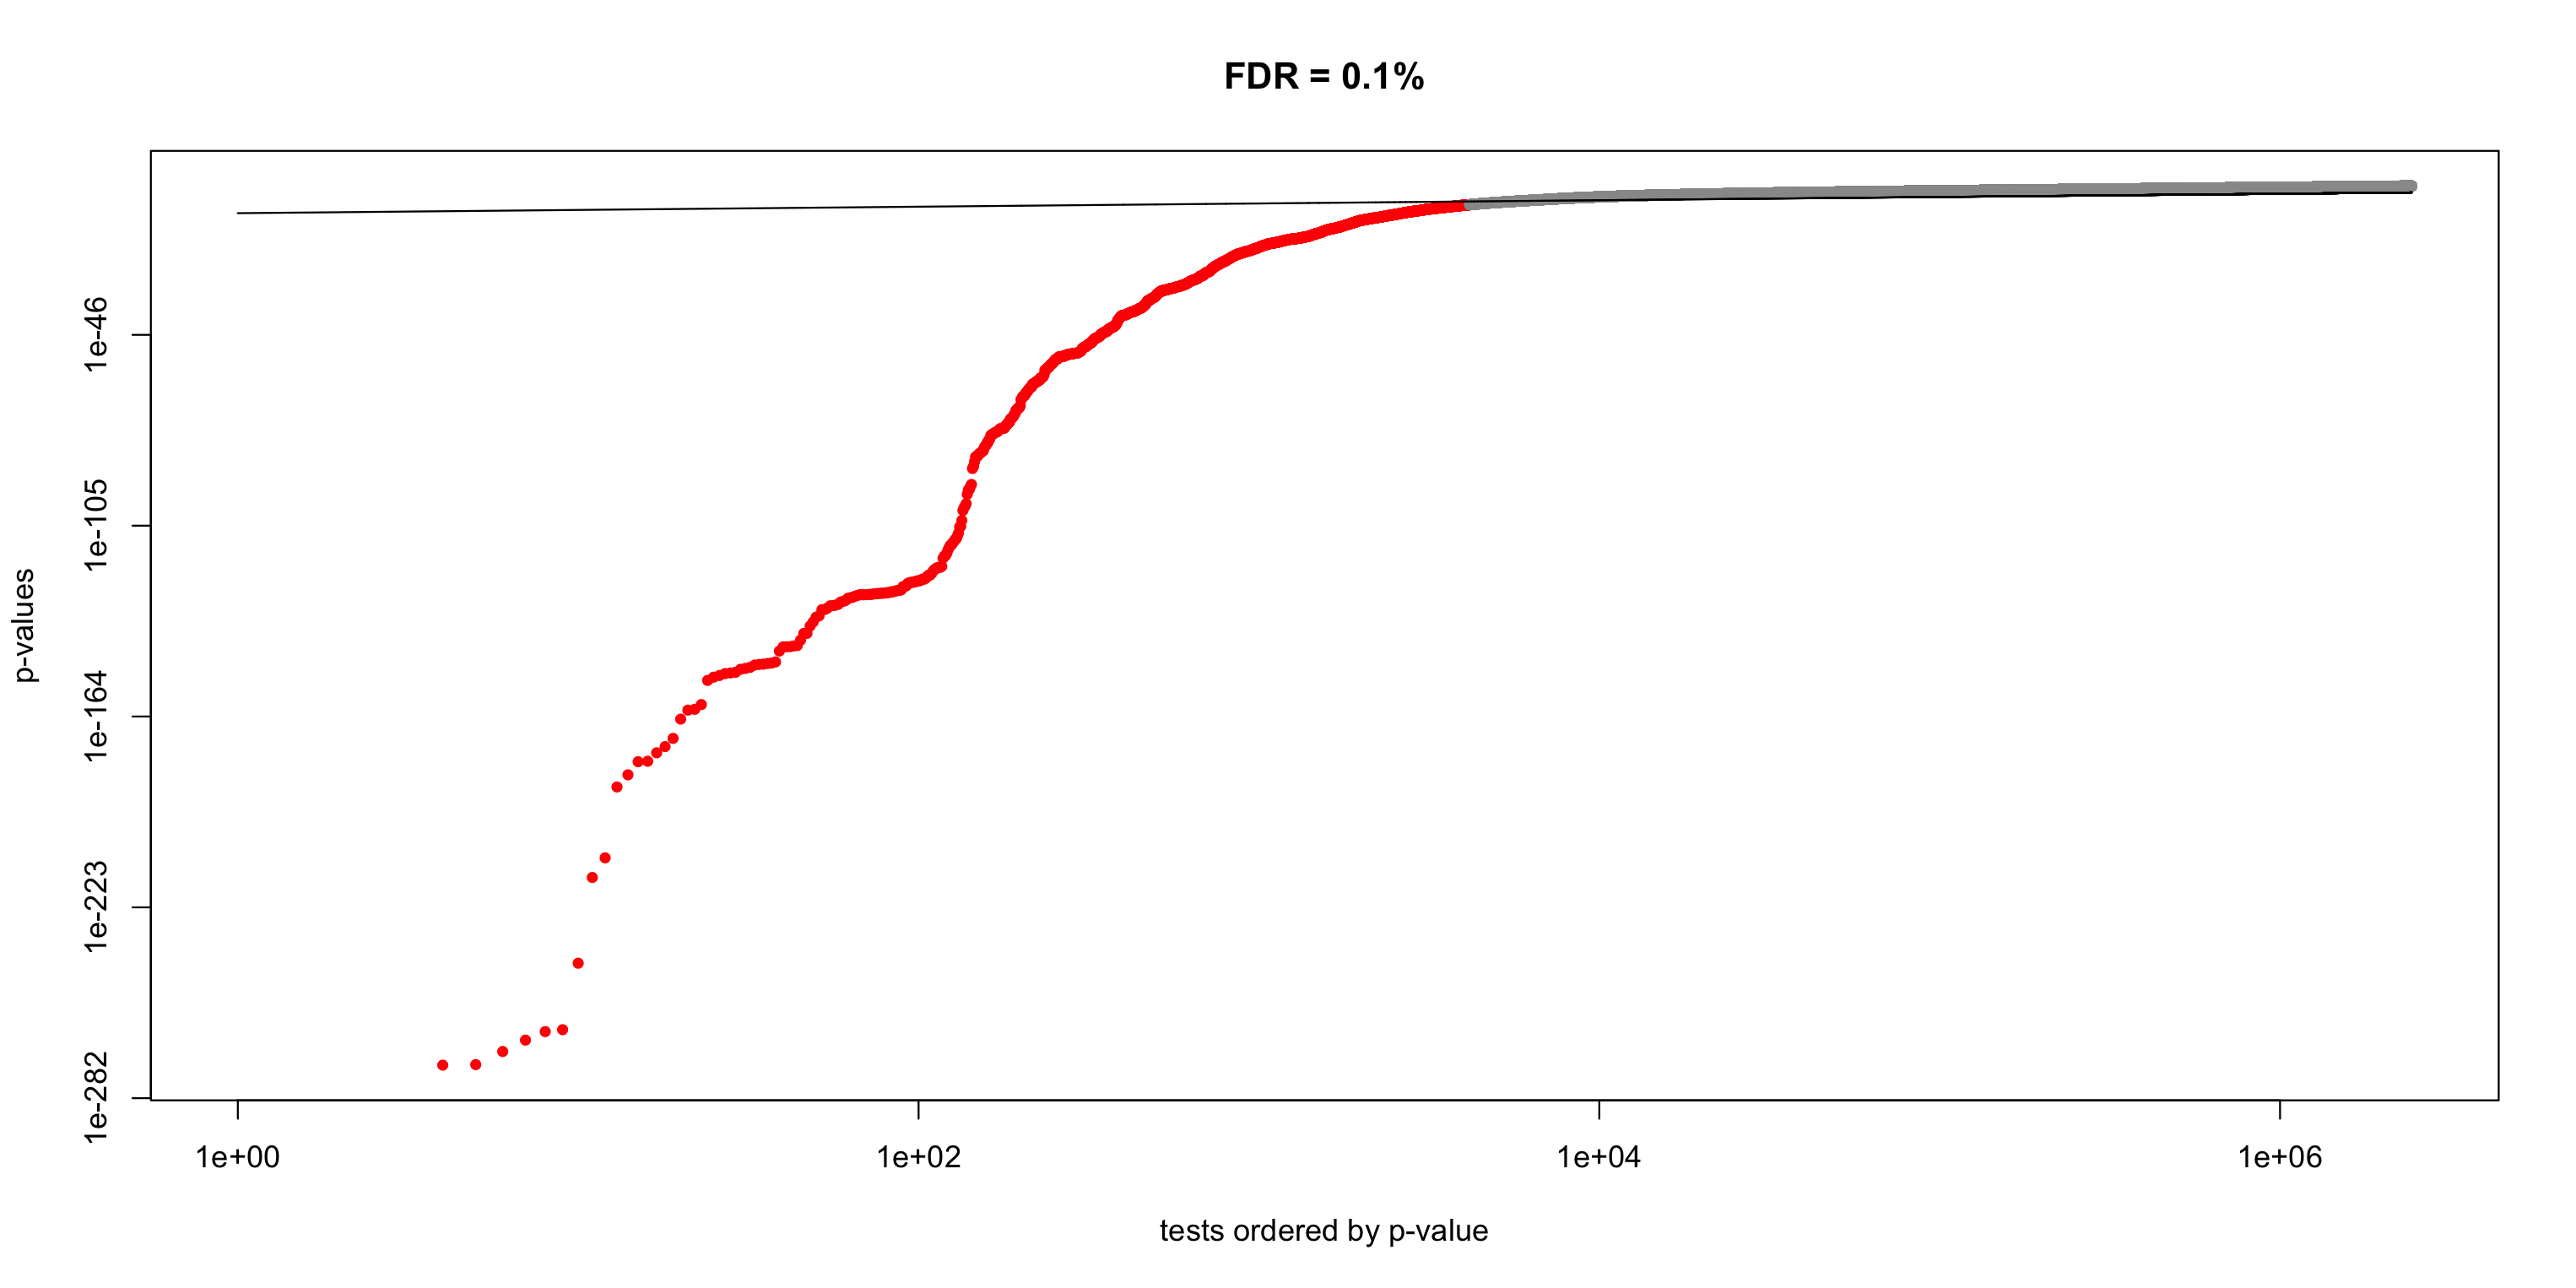

In [35]:
sig <- factor(pvals<=cutoff01)
o <- order(pvals)
N <- length(pvals)
plot(pvals[o], log="xy", col=c("grey60","red")[sig[o]], pch=20, 
     ylab="p-values", xlab="tests ordered by p-value", main = 'FDR = 0.1%')
lines(1:N, 0.01*(1:N)/N)

## Bayesian example

[1] 4 3
[1] 7 5
[1]  7 10
[1]  7 15
[1]  7 20
[1]  9 23
[1]  9 28
[1] 10 32
[1] 12 35
[1] 14 38
[1] 14 43
[1] 17 45
[1] 20 47
[1] 22 50
[1] 23 54
[1] 24 58
[1] 24 63
[1] 24 68
[1] 26 71
[1] 28 74


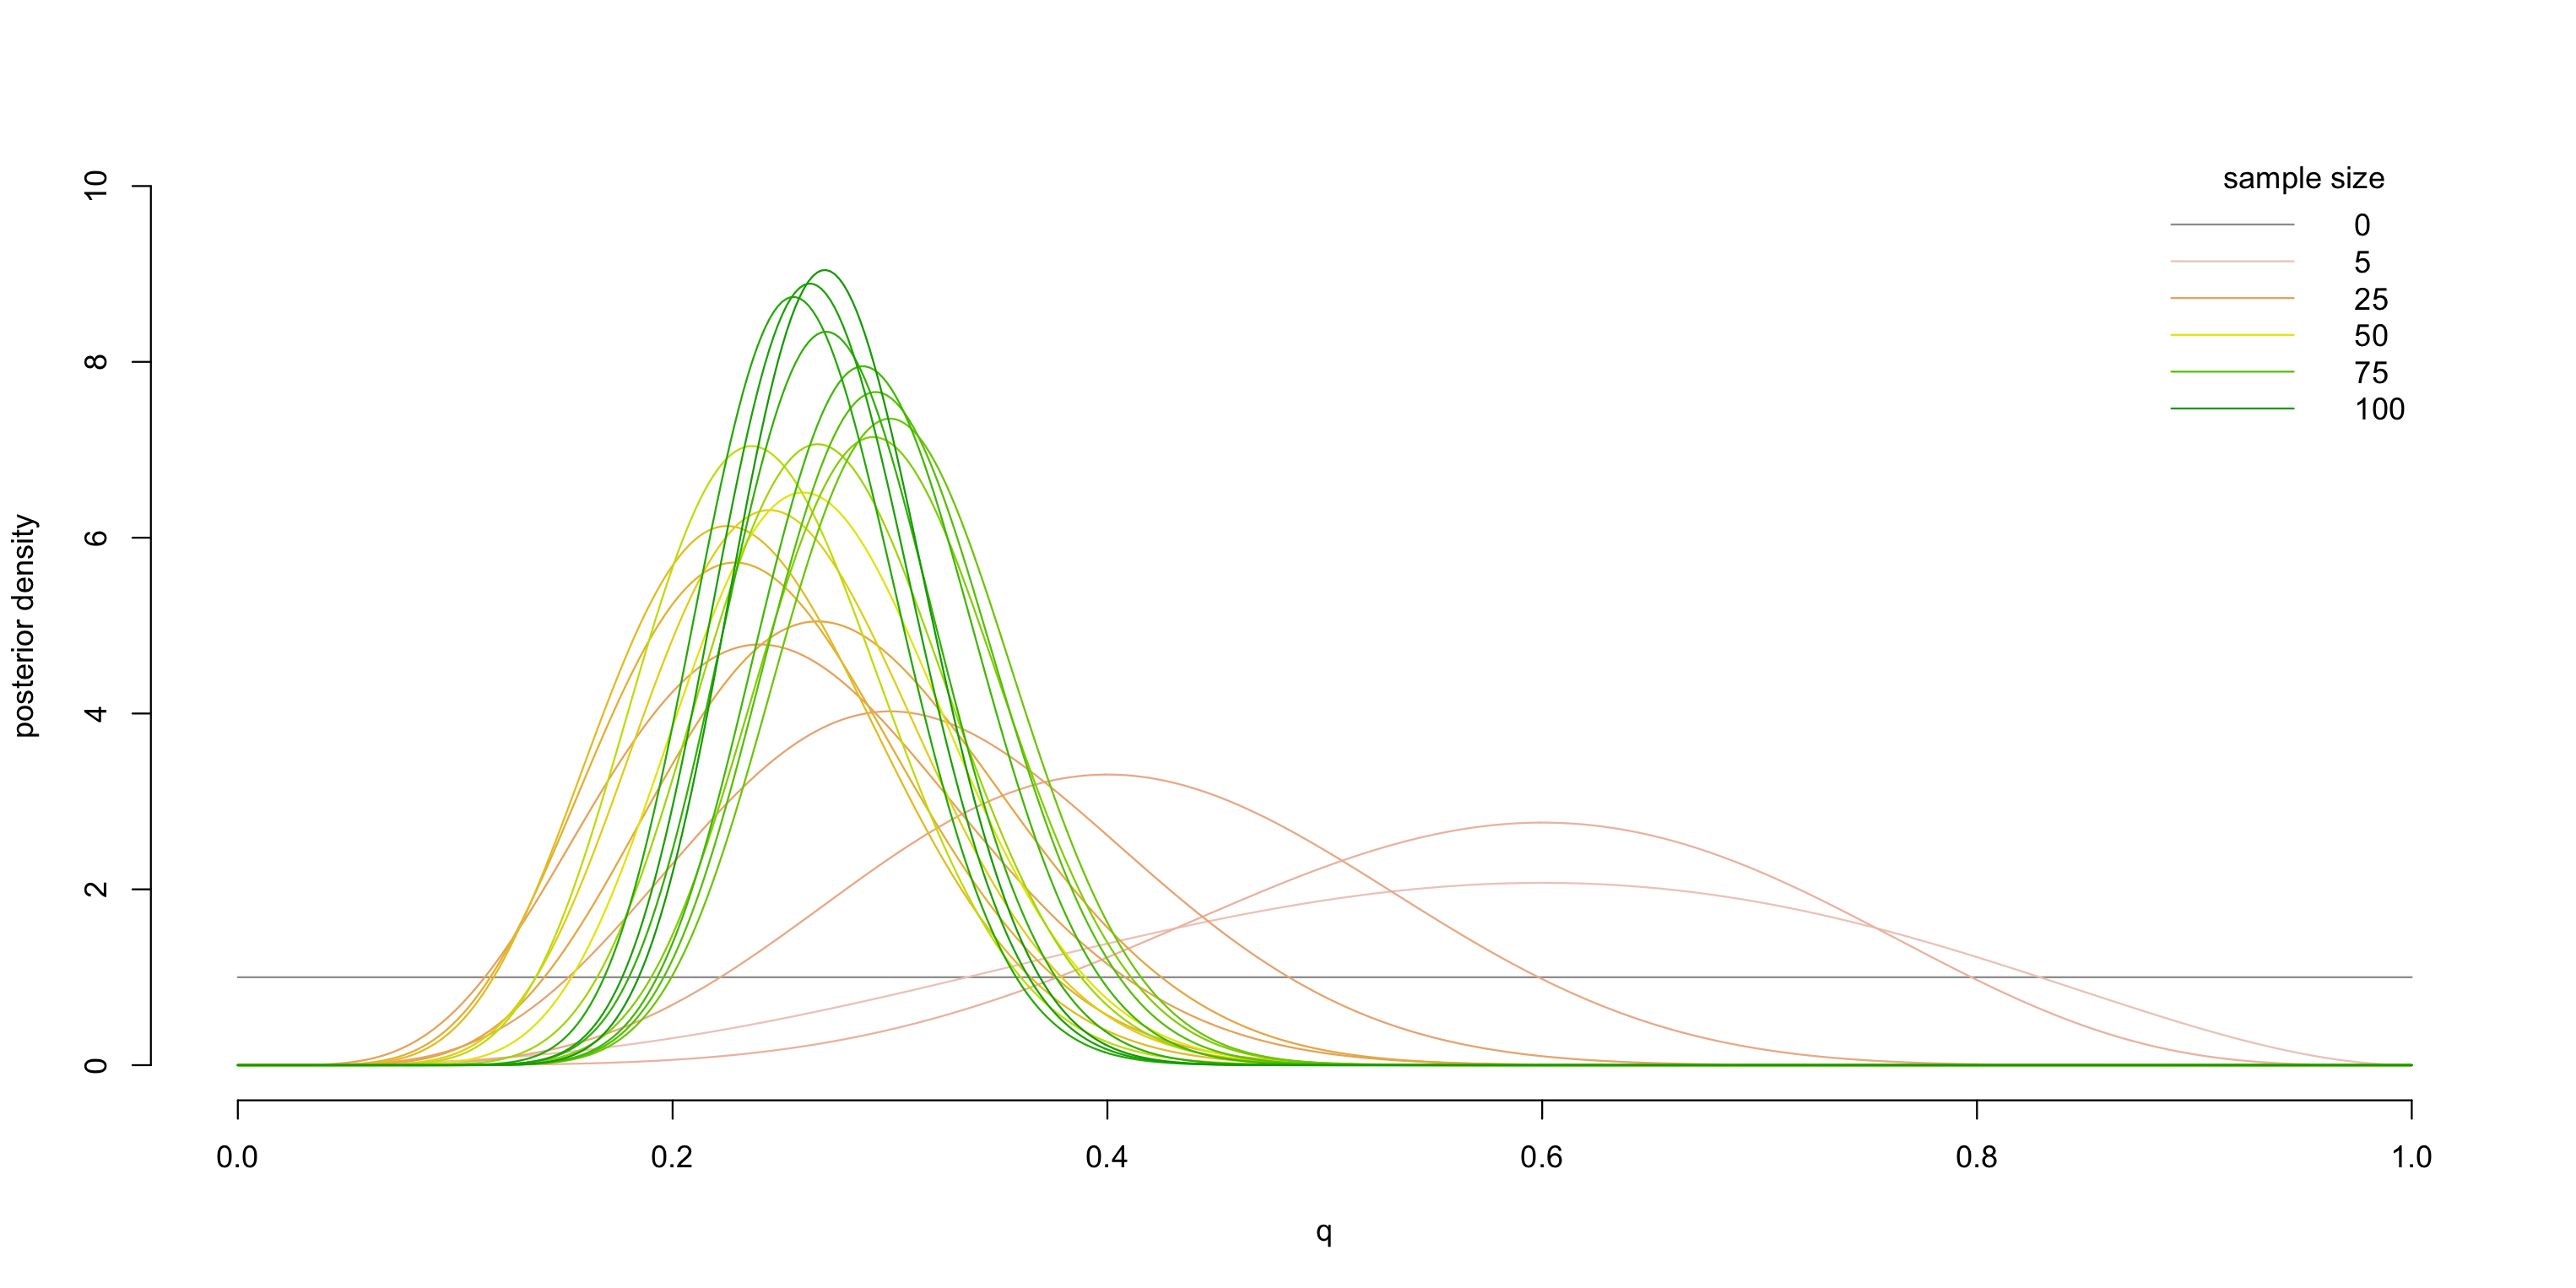

In [36]:
a <- 1
b <- 1
qgrid <- seq(0,1,length=500)
plot(qgrid, dbeta(qgrid, a, b), ylim=c(0,10), col=8,
	type="l", bty="n", lwd=1, xlab="q", ylab="posterior density")

K <- 20
lcols <- terrain.colors(K*1.1)[K:1]
lg <- c(1,5,10,15,20)

for(k in 1:K){
n <- 5
x <- rbinom(n, p=1/3, size=1)
a <- a + sum(x)
b <- b + n - sum(x)
print(c(a,b))
lines(qgrid, dbeta(qgrid,a,b), col=lcols[k], lwd=1)
}
legend("topright", bty="n", title="sample size", 
	legend=c(0,n*lg), col=c(8,lcols[lg]), lwd=1)